We want to study the total spin eigenfunctions of a $5$-spin system.

In [11]:
import numpy as np
from qiskit.circuit.library                   import RYGate,RZGate,RXGate,UGate,NLocal,TwoLocal,RealAmplitudes
from qiskit.circuit                           import Parameter
from qiskit.aqua.components.optimizers        import L_BFGS_B,COBYLA,CG,ADAM,SPSA,AQGD
from qiskit.aqua.components.initial_states    import *
from qiskit.aqua.algorithms                   import VQE
from qiskit.aqua                              import QuantumInstance,aqua_globals

import logging
from qiskit.aqua                              import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG) 

from   qiskit                                 import *
from   qiskit.quantum_info                    import Pauli,Operator
from   qiskit.aqua.operators                  import SummedOp,PauliOp,CircuitStateFn,WeightedPauliOperator
from   qiskit.aqua.operators.primitive_ops    import MatrixOp
from   qiskit.aqua.operators.legacy           import MatrixOperator,op_converter
from   qiskit.aqua.algorithms                 import NumPyEigensolver,NumPyMinimumEigensolver
from   qiskit.compiler                        import transpile

import math
from math                                     import isclose
import matplotlib 
import matplotlib.pyplot as plt
from IPython.display                          import display, Markdown
import itertools

from scipy import linalg as LA

In [12]:
def generate_pauli(idx_x,idx_z,n):
    '''
    Args:
       n   (integer)
       idx (List)
    Returns:
       tensor product of Pauli operators acting on qubits in idx
       Y = iZX
       P0 P1 P2 P3 P4
       Pi = (X)^a (Z)^b
    '''
    xmask = [0]*n
    zmask = [0]*n
    for i in idx_x: xmask[i] = 1
    for i in idx_z: zmask[i] = 1
    a_x = np.asarray(xmask,dtype=np.bool)
    a_z = np.asarray(zmask,dtype=np.bool)
    return Pauli(a_z,a_x)

#The following function is used to define the operators that appear in the Heisenberg hamiltonian above
#In PauliOp the default coefficient is 1.0
def generate_Heisenberg(nqubit,nn_list):
    pauli_list = []
    for (i,j) in nn_list:
        xixj = PauliOp(generate_pauli([i,j],[],nqubit));    pauli_list.append(xixj)
        yiyj = PauliOp(generate_pauli([i,j],[i,j],nqubit)); pauli_list.append(yiyj)
        zizj = PauliOp(generate_pauli([],[i,j],nqubit));    pauli_list.append(zizj)
    H = SummedOp(pauli_list)
    return H

#Here we define the spin operators acting on site i
#We note that this function returns the name of the operator (site+component) and its value
def generate_spin_operators(nqubit):
    spins = []
    for i in range(nqubit):
        xi = generate_pauli([i],[],nqubit);  spins.append( (str(i)+'x',PauliOp(xi,1.0)) )
        yi = generate_pauli([i],[i],nqubit); spins.append( (str(i)+'y',PauliOp(yi,1.0)) )
        zi = generate_pauli([],[i],nqubit);  spins.append( (str(i)+'z',PauliOp(zi,1.0)) )
    return spins

#We note that the argument aux_operators will be the output of function generate_spin_operators
def diagonalize_H(H,aux_operators):
    '''
    k = number of eigenvalues/eigenvectors to find
    H |ci) = Ei |ci)
    Ai = (ci|A|ci)
    aux_ops: list of length k; each element is an array of shape (nprops,2) for real and imaginary part
    '''
    ee = NumPyEigensolver(operator=H,k=2**H.num_qubits,aux_operators=[s for name_s,s in aux_operators])
    ee = ee.run()
    energies = np.real(ee['eigenvalues'])
    psi = ee['eigenstates']
    aux_ops = ee['aux_operator_eigenvalues']
    
    '''
    for i,(ei,ai) in enumerate(zip(energies,aux_ops)):
        print("Eigenstate number: ",i,"; Energy: ",round(ei,6))
        for js,(name_s,s) in enumerate(aux_operators):
            print("     Spin ",name_s,round(ai[js][0],6))  #ai[js] has two arguments: the real and imaginary parts
        print("Eigenvector:")
        psi_i = psi[i].primitive.to_dict()
        for k in psi_i.keys():
            print("     ",k,psi_i[k])
    '''
    return energies,psi,aux_ops

def generate_spinspin_operators(nqubit):
    spin_spin=[]
    for i in range(nqubit):
        for j in range(nqubit):
            xi = PauliOp(generate_pauli([i],[],nqubit));
            xj = PauliOp(generate_pauli([j],[],nqubit));
            
            yi = PauliOp(generate_pauli([i],[i],nqubit));
            yj = PauliOp(generate_pauli([j],[j],nqubit));
            
            zi = PauliOp(generate_pauli([],[i],nqubit));
            zj = PauliOp(generate_pauli([],[j],nqubit));
            
            spin_spin.append( (str(i)+'x-'+str(j)+'x',xi.compose(xj)))
            spin_spin.append( (str(i)+'y-'+str(j)+'y',yi.compose(yj)) )
            spin_spin.append( (str(i)+'z-'+str(j)+'z',zi.compose(zj)) )
            
    return spin_spin

def to_ket(psi):
    """ Write a statevector in braket notation.
    Parameters
    ----------
    ψ: ndarray
        the statevector
    Returns
    -------
    ket: str
        the statevector in braket notation
    """
    # GET WIDTH OF EACH STATE LABEL
    n = int(np.ceil(np.log2(len(psi))))
    # CONSTRUCT STRING ONE STATE AT A TIME
    ket = ""
    for i, c in enumerate(psi):
        # PREPARE STATE LABEL
        label = np.binary_repr(i,n)     # CONVERT INDEX TO CORRESPONDING LABEL
        label = label[::-1]             # (OPTIONAL) USE ALTERNATE INDEXING
        # UPDATE ket STRING
        if np.round(c,3)!=0.:
            if i > 0: ket += " + "
            ket += f"({c:.3f}) |{label}⟩"   # (OPTIONAL) FIX COEFFICIENT'S PRECISION
    return ket

In [13]:
def sign(x):
    if(x>0): 
        return  1
    else:    
        return -1

def convert(x):
    return int(round(np.abs(2*x)))

def get_clebsch(j1,m1,j2,m2,J,M):
    from sympy.physics.quantum.cg import CG
    # S is the shortcut for sympify and converts an arbitrary expression to a type that can be used inside SymPy
    sgnJ  = sign(J) 
    from sympy import S     
    sgnM  = sign(M)
    sgnj1 = sign(j1)
    sgnm1 = sign(m1)
    sgnj2 = sign(j2)
    sgnm2 = sign(m2)
    numJ  = convert(J)
    numM  = convert(M)
    numj1 = convert(j1)
    numm1 = convert(m1)
    numj2 = convert(j2)
    numm2 = convert(m2)
    cg = CG(sgnj1*S(numj1)/2,sgnm1*S(numm1)/2,sgnj2*S(numj2)/2,sgnm2*S(numm2)/2,sgnJ*S(numJ)/2,sgnM*S(numM)/2)
    return float(cg.doit().evalf())

# ------------------------------------------------------

# Remark - It's important to notice that the vector associated with psi_JM is a matrix, therefore the indexes we print in the following function are the
#          matrix indexes on which we have a non-zero value. By this way the indexes can be read also as up or down spin vectors.
#          E.g. (0,1,1) --> (up,down,down)

def print_states(psi_dict):
    for k in psi_dict.keys():
        print("State ",k)
        n = len(psi_dict[k].shape)
        for idx in itertools.product([0,1],repeat=n):
            c = psi_dict[k][idx]
            # If we don't insert the following "if", we would see all the null contributes to the state |J,M>
            if(not isclose(c,0.0,abs_tol=1e-4)):
                print(idx," ",c)
        print(" ")
            
# Given the z-component of spin, m, the following function returns the vectors (1 0)^T (j=1/2, m=1/2) or (0 1)^T (j=1/2, m=-1/2)
def one_spin_states(j,m):
    # isclose returns True if two values are closer than the abs_tol
    if(isclose(m,0.5,abs_tol=1e-4)):        
        i=0
    else:                            
        i=1
    psi    = np.zeros(2)
    psi[i] = 1.0
    return psi[:]

def compose_two_spins(label=''):
    psi = {}
    j1,j2 = 1.0/2.0,1.0/2.0
    for J in [0,1]:
        for M in range(-J,J+1):
            psi_JM = np.zeros((2,2))
            for x1 in [0,1]:
                for x2 in [0,1]:
                    m1,m2 = (x1-j1),(x2-j2)
                    cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                    psi_JM += cg*np.einsum('a,b->ab',one_spin_states(j1,m1),one_spin_states(j2,m2))
            #print(psi_JM)
            psi[label+'_'+str(J)+'_'+str(M)] = psi_JM
    return psi

def compose_with_center(psi_left,label=''):
    psi = {}
    j2 = 1.0/2.0
    for j1 in [0,1]:
        for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
            for M in np.arange(-J,J+1e-4,1.0):
                psi_JM_j1 = np.zeros((2,2,2))
                for x1 in range(2*j1+1):
                    for x2 in [0,1]:
                        m1,m2 = (x1-j1),(x2-j2)
                        cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                        psi_JM_j1 += cg*np.einsum('ab,c->abc',psi_left[label+'_'+str(j1)+'_'+str(m1)],one_spin_states(j2,m2))
                psi[label+'_j1_'+str(j1)+'_lc_'+str(J)+'_'+str(M)] = psi_JM_j1
    return psi

def compose_with_right(psi_lc,psi_r):
    psi={}
    lc_list=[]

    for k in psi_lc.keys():
        klc = k.split('_')
        lab_lc=klc[0]
        jL = float(klc[2])
        j1 = float(klc[4])
        if((jL,j1) not in lc_list):
            lc_list.append((jL,j1))

    for k in psi_r.keys():
        kr=k.split("_")
        lab_r=kr[0]
        break

    for el in lc_list:
        jL=int(el[0])
        j1=el[1]
        #print(jL, " ", j1)
        for j2 in [0,1]:
            for J in np.arange(np.abs(j2-j1),j1+j2+1e-4,1):
                #print(" ",J)
                for M in np.arange(-J,J+1e-4,1.0):
                    # Label with spin left jL, spin right jR and spin left + center jLC 
                    lab = 'jL_'+str(jL)+'_jR_'+str(j2)+'_jLC_'+str(j1)+'_LCR_'+str(J)+'_'+str(M)
                    psi[lab] = np.zeros((2,2,2,2,2))
                    for m1 in np.arange(-j1,j1+1e-4,1):
                        for m2 in np.arange(-j2,j2+1e-4,1):
                            lab1=lab_lc+'_j1_'+str(jL)+'_lc_'+str(j1)+'_'+str(m1)
                            lab2=lab_r+'_'+str(j2)+'_'+str(int(m2))
                            cg = get_clebsch(j1=j1,m1=m1,j2=j2,m2=m2,J=J,M=M)
                            psi[lab] += cg*np.einsum('abc,de->abcde',psi_lc[lab1],psi_r[lab2])
    return psi

In [14]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

We remind that we are working with a "bow-tie" lattice. 

Text(0, 0.5, 'y')

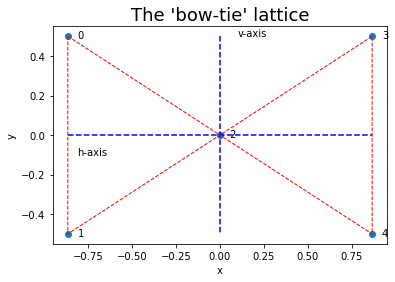

In [15]:
# Make the grid
x=[-0.866,-0.866,0,0.866,0.866]
y=[0.5,-0.5,0,0.5,-0.5]
z=[0,0,0,0,0]

plt.scatter(x,y)
for i,val in enumerate(x):
    plt.annotate(i,(x[i],y[i]), xytext=(x[i]+0.055,y[i]-0.01))
plt.annotate("h-axis",(-0.866,0),xytext=(-0.866+0.055,0-0.1))
plt.annotate("v-axis",(0,0.5),xytext=(0+0.1,0.5))

plt.plot(x,y,"r--",linewidth="1")
plt.plot([-0.866,0.866],[0,0],"b--")
plt.plot([0,0],[0.5,-0.5],"b--")
plt.plot([-0.866,0,0.866],[0.5,0,-0.5],"r--",linewidth="1")
    
plt.title("The 'bow-tie' lattice",fontsize=18)
plt.xlabel("x")
plt.ylabel("y")

**Definition of $H$** Here we define the reference value for the ground state energy. We diagonalize the Heisenberg Hamiltonian.

In [16]:
nqubit  = 5
nn_list = [(0,1),(1,2),(0,2),(2,3),(2,4),(3,4)]
H       = generate_Heisenberg(nqubit,nn_list)

ee = NumPyMinimumEigensolver(H)
result = ee.run()
ref = result.eigenvalue.real
print('Ground state energy: {}'.format(ref))

2021-02-23 14:51:21,506:qiskit.aqua.algorithms.eigen_solvers.numpy_eigen_solver:DEBUG: NumPyEigensolver _run result:
{   'eigvals': array([-6.-1.30104139e-16j]),
    'eigvecs': array([[ 4.51741558e-17+1.22404620e-16j,  3.34358790e-18+5.09491433e-17j,
        -5.61701486e-17-6.33100494e-18j, -1.62556082e-16-9.64598425e-17j,
        -4.98791146e-17+1.31121734e-16j, -1.93569543e-01-1.35257908e-01j,
         1.93569543e-01+1.35257908e-01j, -3.79800564e-16-1.72808297e-17j,
        -9.39659648e-17-4.29396740e-17j,  3.43375235e-01+2.22999740e-01j,
        -3.89928552e-01-2.31362734e-01j,  1.48626846e-02-3.23628175e-02j,
         4.65533175e-02+8.36299440e-03j, -2.44454032e-01+2.37744080e-01j,
         2.29591348e-01-2.05381262e-01j, -7.93736540e-17-2.08983138e-17j,
        -7.75907298e-17-1.07256984e-16j, -1.49805692e-01-8.77418318e-02j,
         1.96359010e-01+9.61048262e-02j, -1.48626846e-02+3.23628175e-02j,
        -4.65533175e-02-8.36299440e-03j,  1.21091240e-01+4.12246078e-02j,
        -

Ground state energy: -6.0000000000000195


We create the Hamiltonian matrix.

In [17]:
mat_H = H.to_matrix()
print(mat_H)

[[6.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 2.+0.j 2.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 2.+0.j 2.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 2.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 2.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 6.+0.j]]


**Definition of $S_x,S_y,S_z,S^2$**

In [18]:
sx=[]
for i in range (nqubit):
    sx.append((1.0/2.,generate_pauli([i],[],nqubit)))
sx=WeightedPauliOperator(sx)
print("Sx operator")
print(sx.print_details())
mat_sx=op_converter.to_matrix_operator(sx).dense_matrix
#print("Sx operator matrix")
#print(mat_sx)

sy=[]
for i in range (nqubit):
    sy.append((1.0/2.,generate_pauli([i],[i],nqubit)))
sy=WeightedPauliOperator(sy)
print("Sy operator")
print(sy.print_details())
mat_sy=op_converter.to_matrix_operator(sy).dense_matrix
#print("Sy operator matrix")
#print(mat_sy)

sz=[]
for i in range (nqubit):
    sz.append((1.0/2.,generate_pauli([],[i],nqubit)))
sz=WeightedPauliOperator(sz)
print("Sz operator")
print(sz.print_details())
mat_sz=op_converter.to_matrix_operator(sz).dense_matrix
#print("Sz operator matrix")
#print(mat_sz)

s2=np.dot(sx,sx)+np.dot(sy,sy)+np.dot(sz,sz)
#print("S2 operator")
#print(s2.print_details())
mat_s2=op_converter.to_matrix_operator(s2).dense_matrix
#print("S2 operator matrix")
#print(mat_s2)

Sx operator
IIIIX	(0.5+0j)
IIIXI	(0.5+0j)
IIXII	(0.5+0j)
IXIII	(0.5+0j)
XIIII	(0.5+0j)

Sy operator
IIIIY	(0.5+0j)
IIIYI	(0.5+0j)
IIYII	(0.5+0j)
IYIII	(0.5+0j)
YIIII	(0.5+0j)

Sz operator
IIIIZ	(0.5+0j)
IIIZI	(0.5+0j)
IIZII	(0.5+0j)
IZIII	(0.5+0j)
ZIIII	(0.5+0j)



We now create the operators spin left, spin right and spin left-middle ($\hat{S}_L$, $\hat{S}_R$, $\hat{S}_{LC}$) which will be used inside the cost function of the **VQE** algorithm.

In [19]:
slx=[]
for i in range (2):
    slx.append((1.0/2.,generate_pauli([i],[],nqubit)))
slx=WeightedPauliOperator(slx)
print("Slx operator")
print(slx.print_details())
mat_slx=op_converter.to_matrix_operator(slx).dense_matrix
#print("Slx operator matrix")
#print(mat_slx)

sly=[]
for i in range (2):
    sly.append((1.0/2.,generate_pauli([i],[i],nqubit)))
sly=WeightedPauliOperator(sly)
print("Sly operator")
print(sly.print_details())
mat_sly=op_converter.to_matrix_operator(sly).dense_matrix
#print("Sly operator matrix")
#print(mat_sly)

slz=[]
for i in range (2):
    slz.append((1.0/2.,generate_pauli([],[i],nqubit)))
slz=WeightedPauliOperator(slz)
print("Slz operator")
print(slz.print_details())
mat_slz=op_converter.to_matrix_operator(slz).dense_matrix
#print("Slz operator matrix")
#print(mat_slz)

sl2=np.dot(slx,slx)+np.dot(sly,sly)+np.dot(slz,slz)
print("Sl2 operator")
print(sl2.print_details())
mat_sl2=op_converter.to_matrix_operator(sl2).dense_matrix
#print("Sl2 operator matrix")
#print(mat_sl2)

srx=[]
for i in range (3,5):
    srx.append((1.0/2.,generate_pauli([i],[],nqubit)))
srx=WeightedPauliOperator(srx)
print("Srx operator")
print(srx.print_details())
mat_srx=op_converter.to_matrix_operator(srx).dense_matrix
#print("Srx operator matrix")
#print(mat_srx)

sry=[]
for i in range (3,5):
    sry.append((1.0/2.,generate_pauli([i],[i],nqubit)))
sry=WeightedPauliOperator(sry)
print("Sry operator")
print(sry.print_details())
mat_sry=op_converter.to_matrix_operator(sry).dense_matrix
#print("Sry operator matrix")
#print(mat_sry)

srz=[]
for i in range (3,5):
    srz.append((1.0/2.,generate_pauli([],[i],nqubit)))
srz=WeightedPauliOperator(srz)
print("Srz operator")
print(srz.print_details())
mat_srz=op_converter.to_matrix_operator(srz).dense_matrix
#print("Srz operator matrix")
#print(mat_srz)

sr2=np.dot(srx,srx)+np.dot(sry,sry)+np.dot(srz,srz)
print("Sr2 operator")
print(sr2.print_details())
mat_sr2=op_converter.to_matrix_operator(sr2).dense_matrix
#print("Sr2 operator matrix")
#print(mat_sr2)

slcx=[]
for i in range (3):
    slcx.append((1.0/2.,generate_pauli([i],[],nqubit)))
slcx=WeightedPauliOperator(slcx)
print("Slcx operator")
print(slcx.print_details())
mat_slcx=op_converter.to_matrix_operator(slcx).dense_matrix
#print("Slcx operator matrix")
#print(mat_slcx)

slcy=[]
for i in range (3):
    slcy.append((1.0/2.,generate_pauli([i],[i],nqubit)))
slcy=WeightedPauliOperator(slcy)
print("Slcy operator")
print(slcy.print_details())
mat_slcy=op_converter.to_matrix_operator(slcy).dense_matrix
#print("Slcy operator matrix")
#print(mat_slcy)

slcz=[]
for i in range (3):
    slcz.append((1.0/2.,generate_pauli([],[i],nqubit)))
slcz=WeightedPauliOperator(slcz)
print("Slcz operator")
print(slcz.print_details())
mat_slcz=op_converter.to_matrix_operator(slcz).dense_matrix
#print("Slcz operator matrix")
#print(mat_slcz)

slc2=np.dot(slcx,slcx)+np.dot(slcy,slcy)+np.dot(slcz,slcz)
print("Slc2 operator")
print(slc2.print_details())
mat_slc2=op_converter.to_matrix_operator(slc2).dense_matrix
#print("Slc2 operator matrix")
#print(mat_slc2)

Slx operator
IIIIX	(0.5+0j)
IIIXI	(0.5+0j)

Sly operator
IIIIY	(0.5+0j)
IIIYI	(0.5+0j)

Slz operator
IIIIZ	(0.5+0j)
IIIZI	(0.5+0j)

Sl2 operator
IIIII	(1.5+0j)
IIIXX	(0.5+0j)
IIIYY	(0.5+0j)
IIIZZ	(0.5+0j)

Srx operator
IXIII	(0.5+0j)
XIIII	(0.5+0j)

Sry operator
IYIII	(0.5+0j)
YIIII	(0.5+0j)

Srz operator
IZIII	(0.5+0j)
ZIIII	(0.5+0j)

Sr2 operator
IIIII	(1.5+0j)
XXIII	(0.5+0j)
YYIII	(0.5+0j)
ZZIII	(0.5+0j)

Slcx operator
IIIIX	(0.5+0j)
IIIXI	(0.5+0j)
IIXII	(0.5+0j)

Slcy operator
IIIIY	(0.5+0j)
IIIYI	(0.5+0j)
IIYII	(0.5+0j)

Slcz operator
IIIIZ	(0.5+0j)
IIIZI	(0.5+0j)
IIZII	(0.5+0j)

Slc2 operator
IIIII	(2.25+0j)
IIIXX	(0.5+0j)
IIXIX	(0.5+0j)
IIXXI	(0.5+0j)
IIIYY	(0.5+0j)
IIYIY	(0.5+0j)
IIYYI	(0.5+0j)
IIIZZ	(0.5+0j)
IIZIZ	(0.5+0j)
IIZZI	(0.5+0j)



# RY Variational Quantum Eigensolver (VQE)

We want to use VQE with a RY variational form. This aim can be reached by using the $\textbf{RealAmplitudes}$ class. 

In [20]:
# Algorithm execution

# 1. On classical computer WITHOUT statistical uncertainties, namely (Psi|H|Psi) algebraically evaluated
backend_1          = Aer.get_backend('statevector_simulator') # <----
quantum_instance_1 = QuantumInstance(backend=backend_1)

# 2. On classical computer WITH statistical uncertainties and hopefully decoherence model
backend_2          = Aer.get_backend('qasm_simulator') # <---- (Psi|H|Psi) sampled
quantum_instance_2 = QuantumInstance(backend=backend_2,shots=8000)

# 3. On quantum computer ...

2021-02-23 14:51:29,706:qiskit.aqua.quantum_instance:INFO: statevector backend only works with shot=1, changing shots from 1024 to 1.
2021-02-23 14:51:29,709:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.16.1
Backend: 'statevector_simulator (AerProvider)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'u', 'p', 'r', 'rx', 'ry', 'rz', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 'sx', 't', 'tdg', 'swap', 'cx', 'cy', 'cz', 'csx', 'cp', 'cu1', 'cu2', 'cu3', 'rxx', 'ryy', 'rzz', 'rzx', 'ccx', 'cswap', 'mcx', 'mcy', 'mcz', 'mcsx', 'mcp', 'mcu1', 'mcu2', 'mcu3', 'mcrx', 'mcry', 'mcrz', 'mcr', 'mcswap', 'unitary', 'diagonal', 'multiplexer', 'initialize', 'kraus', 'roerror', 'delay'], 'coupling_map': None}
{'initial_layout': None, 'seed_transpiler': None, 'optimization_level': None}
RunConfig(max_credits=10, shots=1)
{'timeout': None}
{}
{}
Measurement mitigation: None
2021-02-23 14:51:29,711:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.16.1
Backend: 'qasm_si

We select as **initial state** $\psi_1=|0\rangle^{\otimes 5}$ and an entanglement structure connected with the topology of the "bow-tie" lattice.

In [54]:
psi_1   = Zero(H.num_qubits)                            # tensor product of zeros: |0)|0)|0)|0)|0)
#psi_1_c = psi_1.construct_circuit()
#display(Markdown(r"Initial state $\psi_1=|0\rangle^{\otimes 5}$"))
#print(psi_1_c.draw())

#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(H.num_qubits,entanglement=nn_list,initial_state=psi_1,insert_barriers=True,reps=1)
#print("Number of parameters: "+str(var_form.num_parameters))

print(var_form.draw())

     ┌──────────┐ ░                                ░ ┌──────────┐
q_0: ┤ RY(θ[0]) ├─░───■─────────■──────────────────░─┤ RY(θ[5]) ├
     ├──────────┤ ░ ┌─┴─┐       │                  ░ ├──────────┤
q_1: ┤ RY(θ[1]) ├─░─┤ X ├──■────┼──────────────────░─┤ RY(θ[6]) ├
     ├──────────┤ ░ └───┘┌─┴─┐┌─┴─┐                ░ ├──────────┤
q_2: ┤ RY(θ[2]) ├─░──────┤ X ├┤ X ├──■────■────────░─┤ RY(θ[7]) ├
     ├──────────┤ ░      └───┘└───┘┌─┴─┐  │        ░ ├──────────┤
q_3: ┤ RY(θ[3]) ├─░────────────────┤ X ├──┼────■───░─┤ RY(θ[8]) ├
     ├──────────┤ ░                └───┘┌─┴─┐┌─┴─┐ ░ ├──────────┤
q_4: ┤ RY(θ[4]) ├─░─────────────────────┤ X ├┤ X ├─░─┤ RY(θ[9]) ├
     └──────────┘ ░                     └───┘└───┘ ░ └──────────┘


In [55]:
optimizers=[CG(maxiter=50,gtol=1e-07),L_BFGS_B(maxiter=10000,epsilon=1e-12)]
name_opt=["CG","L_BFGS_B"]

converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print('Optimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
  
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    algo = VQE(H, var_form, optimizer, callback=store_intermediate_result)   #,aux_operators=A_op)
    algo_result      = algo.run(quantum_instance_1)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
    for k in algo_result:
        print(k,algo_result[k])

2021-02-19 14:15:11,409:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  IIIXX,
  IIIYY,
  IIIZZ,
  IIXXI,
  IIYYI,
  IIZZI,
  IIXIX,
  IIYIY,
  IIZIZ,
  IXXII,
  IYYII,
  IZZII,
  XIXII,
  YIYII,
  ZIZII,
  XXIII,
  YYIII,
  ZZIII
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7f9a4ed0bc70>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7f9a4ed0bdc0>>
-- initial_point: Random seed
-- var_form:      ┌──────────┐ ░                                ░ ┌──────────┐
q_0: ┤ RY(θ[0]) ├─░───■─────────■──────────────────░─┤ RY(θ[5]) ├
     ├──────────┤ ░ ┌─┴─┐       │                  ░ ├──────────┤
q_1: ┤

2021-02-19 14:15:11,437:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2021-02-19 14:15:11,439:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operations with depth 8
op_counts: OrderedDict([('ry', 10), ('cx', 6), ('barrier', 2)])

2021-02-19 14:15:11,444:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.20403 (ms)
2021-02-19 14:15:11,452:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [4.04419959] - 19.25898 (ms), eval count: 1
2021-02-19 14:15:11,455:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.84703 (ms)
2021-02-19 14:15:11,460:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [4.0441996] - 6.69694 (ms), eval count: 2
2021-02-19 14:15:11,462:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98300 (ms)
2021-02-19 14:15:11,467:qiskit.aqua.algorithms.minim

Optimizer: CG        

2021-02-19 14:15:11,615:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.6252322] - 7.69591 (ms), eval count: 20
2021-02-19 14:15:11,622:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.34921 (ms)
2021-02-19 14:15:11,625:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.62523219] - 4.19712 (ms), eval count: 21
2021-02-19 14:15:11,630:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18813 (ms)
2021-02-19 14:15:11,635:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [0.62523219] - 8.24976 (ms), eval count: 22
2021-02-19 14:15:11,639:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.11103 (ms)
2021-02-19 14:15:11,645:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.84381066] - 7.59888 (ms), eval count: 23
2021-02-19 14:15:11,649:qiskit.aqua.operators.converters.c

2021-02-19 14:15:11,959:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.49193038] - 9.55391 (ms), eval count: 51
2021-02-19 14:15:11,965:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21713 (ms)
2021-02-19 14:15:11,970:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.49193037] - 6.46281 (ms), eval count: 52
2021-02-19 14:15:11,972:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.07718 (ms)
2021-02-19 14:15:11,977:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.49193038] - 5.91707 (ms), eval count: 53
2021-02-19 14:15:11,980:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21117 (ms)
2021-02-19 14:15:11,985:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.49193036] - 7.13778 (ms), eval count: 54
2021-02-19 14:15:11,988:qiskit.aqua.operators.converte

2021-02-19 14:15:12,323:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96445846] - 8.32200 (ms), eval count: 82
2021-02-19 14:15:12,326:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15514 (ms)
2021-02-19 14:15:12,330:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96445847] - 4.81510 (ms), eval count: 83
2021-02-19 14:15:12,334:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98515 (ms)
2021-02-19 14:15:12,337:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96445846] - 4.81296 (ms), eval count: 84
2021-02-19 14:15:12,341:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.05500 (ms)
2021-02-19 14:15:12,351:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96445846] - 11.34992 (ms), eval count: 85
2021-02-19 14:15:12,354:qiskit.aqua.operators.convert

2021-02-19 14:15:12,632:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99349491] - 7.51710 (ms), eval count: 113
2021-02-19 14:15:12,634:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01018 (ms)
2021-02-19 14:15:12,639:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99349491] - 5.83696 (ms), eval count: 114
2021-02-19 14:15:12,645:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.69182 (ms)
2021-02-19 14:15:12,651:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99349491] - 7.58386 (ms), eval count: 115
2021-02-19 14:15:12,655:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02210 (ms)
2021-02-19 14:15:12,660:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99349491] - 6.28519 (ms), eval count: 116
2021-02-19 14:15:12,663:qiskit.aqua.operators.conv

2021-02-19 14:15:12,976:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99764204] - 6.40798 (ms), eval count: 144
2021-02-19 14:15:12,988:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.08809 (ms)
2021-02-19 14:15:12,994:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99764204] - 11.31606 (ms), eval count: 145
2021-02-19 14:15:12,998:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98300 (ms)
2021-02-19 14:15:13,004:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99764204] - 6.85596 (ms), eval count: 146
2021-02-19 14:15:13,008:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.91426 (ms)
2021-02-19 14:15:13,015:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99764204] - 8.71205 (ms), eval count: 147
2021-02-19 14:15:13,022:qiskit.aqua.operators.con

2021-02-19 14:15:13,381:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99953311] - 13.90386 (ms), eval count: 175
2021-02-19 14:15:13,383:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.49298 (ms)
2021-02-19 14:15:13,394:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99953311] - 12.79593 (ms), eval count: 176
2021-02-19 14:15:13,397:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.11794 (ms)
2021-02-19 14:15:13,406:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99987259] - 10.49876 (ms), eval count: 177
2021-02-19 14:15:13,411:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98705 (ms)
2021-02-19 14:15:13,418:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99987259] - 8.48103 (ms), eval count: 178
2021-02-19 14:15:13,428:qiskit.aqua.operators.c

2021-02-19 14:15:13,692:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99991976] - 4.96387 (ms), eval count: 206
2021-02-19 14:15:13,695:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.77908 (ms)
2021-02-19 14:15:13,699:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99991976] - 5.33605 (ms), eval count: 207
2021-02-19 14:15:13,702:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.67608 (ms)
2021-02-19 14:15:13,709:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99991976] - 8.87418 (ms), eval count: 208
2021-02-19 14:15:13,714:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.43299 (ms)
2021-02-19 14:15:13,721:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99991976] - 10.47993 (ms), eval count: 209
2021-02-19 14:15:13,726:qiskit.aqua.operators.con

2021-02-19 14:15:14,005:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99997237] - 6.77299 (ms), eval count: 237
2021-02-19 14:15:14,007:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98920 (ms)
2021-02-19 14:15:14,012:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99997237] - 5.41806 (ms), eval count: 238
2021-02-19 14:15:14,018:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.52008 (ms)
2021-02-19 14:15:14,025:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99997237] - 10.12802 (ms), eval count: 239
2021-02-19 14:15:14,028:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40500 (ms)
2021-02-19 14:15:14,032:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99997237] - 5.91683 (ms), eval count: 240
2021-02-19 14:15:14,037:qiskit.aqua.operators.con

2021-02-19 14:15:14,292:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998504] - 5.09524 (ms), eval count: 268
2021-02-19 14:15:14,295:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.60885 (ms)
2021-02-19 14:15:14,299:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998504] - 5.96189 (ms), eval count: 269
2021-02-19 14:15:14,301:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.11485 (ms)
2021-02-19 14:15:14,307:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998504] - 7.17998 (ms), eval count: 270
2021-02-19 14:15:14,312:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94995 (ms)
2021-02-19 14:15:14,329:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998504] - 19.59014 (ms), eval count: 271
2021-02-19 14:15:14,333:qiskit.aqua.operators.con

2021-02-19 14:15:14,671:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999945] - 10.57816 (ms), eval count: 299
2021-02-19 14:15:14,681:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.04284 (ms)
2021-02-19 14:15:14,687:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999945] - 7.76505 (ms), eval count: 300
2021-02-19 14:15:14,695:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.54018 (ms)
2021-02-19 14:15:14,715:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999945] - 21.58070 (ms), eval count: 301
2021-02-19 14:15:14,722:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.75390 (ms)
2021-02-19 14:15:14,731:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999945] - 13.30304 (ms), eval count: 302
2021-02-19 14:15:14,733:qiskit.aqua.operators.conve

2021-02-19 14:15:15,127:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999615] - 13.46993 (ms), eval count: 330
2021-02-19 14:15:15,132:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.08624 (ms)
2021-02-19 14:15:15,140:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999782] - 8.14295 (ms), eval count: 331
2021-02-19 14:15:15,146:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.81215 (ms)
2021-02-19 14:15:15,155:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999782] - 11.73401 (ms), eval count: 332
2021-02-19 14:15:15,163:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.06304 (ms)
2021-02-19 14:15:15,167:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999782] - 6.64401 (ms), eval count: 333
2021-02-19 14:15:15,174:qiskit.aqua.operators.co

2021-02-19 14:15:15,574:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999985] - 7.36785 (ms), eval count: 361
2021-02-19 14:15:15,579:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.54614 (ms)
2021-02-19 14:15:15,583:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999985] - 6.57105 (ms), eval count: 362
2021-02-19 14:15:15,595:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.47900 (ms)
2021-02-19 14:15:15,599:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999985] - 7.60508 (ms), eval count: 363
2021-02-19 14:15:15,608:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.22104 (ms)
2021-02-19 14:15:15,616:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999999] - 11.40881 (ms), eval count: 364
2021-02-19 14:15:15,619:qiskit.aqua.operators.conv

2021-02-19 14:15:15,980:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999995] - 10.01215 (ms), eval count: 392
2021-02-19 14:15:15,984:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.78504 (ms)
2021-02-19 14:15:15,994:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999995] - 11.50203 (ms), eval count: 393
2021-02-19 14:15:15,996:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.49179 (ms)
2021-02-19 14:15:16,006:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999995] - 11.54375 (ms), eval count: 394
2021-02-19 14:15:16,009:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23596 (ms)
2021-02-19 14:15:16,016:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999995] - 8.29196 (ms), eval count: 395
2021-02-19 14:15:16,018:qiskit.aqua.operators.c

2021-02-19 14:15:16,324:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 22.05181 (ms), eval count: 423
2021-02-19 14:15:16,327:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98610 (ms)
2021-02-19 14:15:16,335:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 9.22132 (ms), eval count: 424
2021-02-19 14:15:16,337:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.25408 (ms)
2021-02-19 14:15:16,342:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 6.11806 (ms), eval count: 425
2021-02-19 14:15:16,347:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.29621 (ms)
2021-02-19 14:15:16,352:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 7.66635 (ms), eval count: 426
2021-02-19 14:15:16,358:qiskit.aqua.operators.con

2021-02-19 14:15:16,670:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 8.00705 (ms), eval count: 454
2021-02-19 14:15:16,677:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.10493 (ms)
2021-02-19 14:15:16,683:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 9.97210 (ms), eval count: 455
2021-02-19 14:15:16,689:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.43823 (ms)
2021-02-19 14:15:16,700:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 14.28986 (ms), eval count: 456
2021-02-19 14:15:16,704:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.08084 (ms)
2021-02-19 14:15:16,718:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 16.78419 (ms), eval count: 457
2021-02-19 14:15:16,728:qiskit.aqua.operators.co

2021-02-19 14:15:17,109:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02091 (ms)
2021-02-19 14:15:17,116:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.46012 (ms), eval count: 486
2021-02-19 14:15:17,122:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.73490 (ms)
2021-02-19 14:15:17,128:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.14383 (ms), eval count: 487
2021-02-19 14:15:17,130:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02496 (ms)
2021-02-19 14:15:17,136:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.27303 (ms), eval count: 488
2021-02-19 14:15:17,142:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.32489 (ms)
2021-02-19 14:15:17,145:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2021-02-19 14:15:17,546:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.18296 (ms)
2021-02-19 14:15:17,551:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.96826 (ms), eval count: 518
2021-02-19 14:15:17,557:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.55592 (ms)
2021-02-19 14:15:17,562:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.42507 (ms), eval count: 519
2021-02-19 14:15:17,565:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00994 (ms)
2021-02-19 14:15:17,577:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.57412 (ms), eval count: 520
2021-02-19 14:15:17,579:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.95510 (ms)
2021-02-19 14:15:17,586:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.]

2021-02-19 14:15:17,849:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96989 (ms)
2021-02-19 14:15:17,854:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.91397 (ms), eval count: 550
2021-02-19 14:15:17,859:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14298 (ms)
2021-02-19 14:15:17,869:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.74672 (ms), eval count: 551
2021-02-19 14:15:17,874:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.43313 (ms)
2021-02-19 14:15:17,880:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.44820 (ms), eval count: 552
2021-02-19 14:15:17,883:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.72496 (ms)
2021-02-19 14:15:17,887:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.]

2021-02-19 14:15:18,282:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99111 (ms)
2021-02-19 14:15:18,296:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.45198 (ms), eval count: 582
2021-02-19 14:15:18,298:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23096 (ms)
2021-02-19 14:15:18,304:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.33185 (ms), eval count: 583
2021-02-19 14:15:18,317:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.08099 (ms)
2021-02-19 14:15:18,324:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.38096 (ms), eval count: 584
2021-02-19 14:15:18,327:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01495 (ms)
2021-02-19 14:15:18,332:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.]

2021-02-19 14:15:18,607:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.29883 (ms)
2021-02-19 14:15:18,615:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.89413 (ms), eval count: 614
2021-02-19 14:15:18,619:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.10602 (ms)
2021-02-19 14:15:18,625:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.59895 (ms), eval count: 615
2021-02-19 14:15:18,628:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00899 (ms)
2021-02-19 14:15:18,633:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.50413 (ms), eval count: 616
2021-02-19 14:15:18,636:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.29199 (ms)
2021-02-19 14:15:18,641:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2021-02-19 14:15:18,924:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.86110 (ms)
2021-02-19 14:15:18,929:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.38795 (ms), eval count: 646
2021-02-19 14:15:18,931:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98014 (ms)
2021-02-19 14:15:18,939:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.38010 (ms), eval count: 647
2021-02-19 14:15:18,941:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99683 (ms)
2021-02-19 14:15:18,947:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.21908 (ms), eval count: 648
2021-02-19 14:15:18,949:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01137 (ms)
2021-02-19 14:15:18,958:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2021-02-19 14:15:19,251:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97704 (ms)
2021-02-19 14:15:19,257:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.95014 (ms), eval count: 678
2021-02-19 14:15:19,261:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97179 (ms)
2021-02-19 14:15:19,265:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.14913 (ms), eval count: 679
2021-02-19 14:15:19,269:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00732 (ms)
2021-02-19 14:15:19,278:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.40411 (ms), eval count: 680
2021-02-19 14:15:19,284:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.29485 (ms)
2021-02-19 14:15:19,290:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.]

2021-02-19 14:15:19,567:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.93286 (ms)
2021-02-19 14:15:19,574:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.88300 (ms), eval count: 710
2021-02-19 14:15:19,577:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.72687 (ms)
2021-02-19 14:15:19,582:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.92797 (ms), eval count: 711
2021-02-19 14:15:19,586:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.69516 (ms)
2021-02-19 14:15:19,591:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.77013 (ms), eval count: 712
2021-02-19 14:15:19,596:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.74475 (ms)
2021-02-19 14:15:19,603:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2021-02-19 14:15:19,885:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.68705 (ms)
2021-02-19 14:15:19,891:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.03692 (ms), eval count: 742
2021-02-19 14:15:19,895:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.77002 (ms)
2021-02-19 14:15:19,903:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.12309 (ms), eval count: 743
2021-02-19 14:15:19,908:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.80292 (ms)
2021-02-19 14:15:19,915:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.62908 (ms), eval count: 744
2021-02-19 14:15:19,918:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.71518 (ms)
2021-02-19 14:15:19,923:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2021-02-19 14:15:20,217:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.79291 (ms)
2021-02-19 14:15:20,223:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.19492 (ms), eval count: 774
2021-02-19 14:15:20,225:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01495 (ms)
2021-02-19 14:15:20,229:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.81009 (ms), eval count: 775
2021-02-19 14:15:20,232:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.74904 (ms)
2021-02-19 14:15:20,236:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.24211 (ms), eval count: 776
2021-02-19 14:15:20,239:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.76597 (ms)
2021-02-19 14:15:20,247:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2021-02-19 14:15:20,526:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02179 (ms)
2021-02-19 14:15:20,531:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.20406 (ms), eval count: 806
2021-02-19 14:15:20,534:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.66297 (ms)
2021-02-19 14:15:20,538:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.08706 (ms), eval count: 807
2021-02-19 14:15:20,542:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.54710 (ms)
2021-02-19 14:15:20,548:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.07905 (ms), eval count: 808
2021-02-19 14:15:20,554:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.34087 (ms)
2021-02-19 14:15:20,561:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2021-02-19 14:15:20,831:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.30296 (ms)
2021-02-19 14:15:20,835:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.79500 (ms), eval count: 838
2021-02-19 14:15:20,839:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.80888 (ms)
2021-02-19 14:15:20,849:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.28602 (ms), eval count: 839
2021-02-19 14:15:20,852:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99897 (ms)
2021-02-19 14:15:20,861:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.61471 (ms), eval count: 840
2021-02-19 14:15:20,863:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.95534 (ms)
2021-02-19 14:15:20,869:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.]

2021-02-19 14:15:21,155:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.36320 (ms)
2021-02-19 14:15:21,161:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.50797 (ms), eval count: 870
2021-02-19 14:15:21,163:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97418 (ms)
2021-02-19 14:15:21,168:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.87010 (ms), eval count: 871
2021-02-19 14:15:21,173:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.70915 (ms)
2021-02-19 14:15:21,178:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.57885 (ms), eval count: 872
2021-02-19 14:15:21,181:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96989 (ms)
2021-02-19 14:15:21,185:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2021-02-19 14:15:21,462:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.67108 (ms)
2021-02-19 14:15:21,468:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.08771 (ms), eval count: 902
2021-02-19 14:15:21,472:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.61283 (ms)
2021-02-19 14:15:21,483:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.79704 (ms), eval count: 903
2021-02-19 14:15:21,487:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.60193 (ms)
2021-02-19 14:15:21,492:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.62088 (ms), eval count: 904
2021-02-19 14:15:21,495:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.70493 (ms)
2021-02-19 14:15:21,499:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.]

2021-02-19 14:15:21,780:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.87683 (ms)
2021-02-19 14:15:21,784:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.52289 (ms), eval count: 934
2021-02-19 14:15:21,788:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.73807 (ms)
2021-02-19 14:15:21,795:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.47881 (ms), eval count: 935
2021-02-19 14:15:21,801:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.62499 (ms)
2021-02-19 14:15:21,805:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.50089 (ms), eval count: 936
2021-02-19 14:15:21,812:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.53494 (ms)
2021-02-19 14:15:21,819:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] 

2021-02-19 14:15:22,201:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.47700 (ms)
2021-02-19 14:15:22,209:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.31787 (ms), eval count: 966
2021-02-19 14:15:22,216:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.79696 (ms)
2021-02-19 14:15:22,221:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.08015 (ms), eval count: 967
2021-02-19 14:15:22,231:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.07109 (ms)
2021-02-19 14:15:22,237:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.68291 (ms), eval count: 968
2021-02-19 14:15:22,248:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 5.02014 (ms)
2021-02-19 14:15:22,252:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.]

2021-02-19 14:15:22,637:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.93699 (ms)
2021-02-19 14:15:22,647:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.49089 (ms), eval count: 998
2021-02-19 14:15:22,650:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.68705 (ms)
2021-02-19 14:15:22,653:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.60482 (ms), eval count: 999
2021-02-19 14:15:22,660:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92015 (ms)
2021-02-19 14:15:22,669:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.65318 (ms), eval count: 1000
2021-02-19 14:15:22,672:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.47486 (ms)
2021-02-19 14:15:22,683:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2021-02-19 14:15:23,022:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.68197 (ms)
2021-02-19 14:15:23,028:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.37207 (ms), eval count: 1030
2021-02-19 14:15:23,032:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.19011 (ms)
2021-02-19 14:15:23,040:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.61416 (ms), eval count: 1031
2021-02-19 14:15:23,044:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.08218 (ms)
2021-02-19 14:15:23,051:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.93402 (ms), eval count: 1032
2021-02-19 14:15:23,057:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.30598 (ms)
2021-02-19 14:15:23,063:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-

2021-02-19 14:15:23,355:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.45793 (ms)
2021-02-19 14:15:23,362:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.86083 (ms), eval count: 1062
2021-02-19 14:15:23,369:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.95701 (ms)
2021-02-19 14:15:23,386:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 17.76218 (ms), eval count: 1063
2021-02-19 14:15:23,388:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.93317 (ms)
2021-02-19 14:15:23,399:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.30884 (ms), eval count: 1064
2021-02-19 14:15:23,404:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.55902 (ms)
2021-02-19 14:15:23,422:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2021-02-19 14:15:23,823:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.51906 (ms)
2021-02-19 14:15:23,828:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.74019 (ms), eval count: 1094
2021-02-19 14:15:23,832:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98991 (ms)
2021-02-19 14:15:23,835:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 3.96085 (ms), eval count: 1095
2021-02-19 14:15:23,839:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97108 (ms)
2021-02-19 14:15:23,845:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.61509 (ms), eval count: 1096
2021-02-19 14:15:23,848:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.11699 (ms)
2021-02-19 14:15:23,854:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2021-02-19 14:15:24,311:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 1.10812368 -1.46661668  1.55918371 -2.95729907  0.38776864  0.16057675
 -1.82861517 -0.42830593  2.94891666  1.49035584]
2021-02-19 14:15:24,326:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2021-02-19 14:15:24,329:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operations with depth 8
op_counts: OrderedDict([('ry', 10), ('cx', 6), ('barrier', 2)])

2021-02-19 14:15:24,332:qiskit.aqua.quantum_instanc

optimal_parameters {Parameter(θ[0]): 1.570796357957937, Parameter(θ[1]): -6.006504606034052e-08, Parameter(θ[2]): 4.408493277916924, Parameter(θ[3]): 2.837696941125386, Parameter(θ[4]): 3.141593251477312, Parameter(θ[5]): 1.9011311534008546, Parameter(θ[6]): -1.2404615388058815, Parameter(θ[7]): -0.12515096892493993, Parameter(θ[8]): -0.42904657607003194, Parameter(θ[9]): 1.4456453947466785}
optimal_point [ 1.57079636e+00 -6.00650461e-08  4.40849328e+00  2.83769694e+00
  3.14159325e+00  1.90113115e+00 -1.24046154e+00 -1.25150969e-01
 -4.29046576e-01  1.44564539e+00]
optimal_value -5.999999999999959
optimizer_evals 1123
optimizer_time 12.867799997329712
eigenvalue (-5.999999999999959+0j)
eigenstate [ 1.53081396e-10+0.j  2.06807450e-08+0.j -2.15736152e-08+0.j
 -1.53082197e-10+0.j -1.65494633e-08+0.j  4.01436417e-01+0.j
 -4.01436404e-01+0.j  1.04721612e-09+0.j  1.51118225e-08+0.j
 -3.20586576e-01+0.j  3.20586555e-01+0.j -2.73174910e-09+0.j
  5.06782362e-09+0.j -1.25894422e-01+0.j  1.25894

2021-02-19 14:15:24,520:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20115 (ms)
2021-02-19 14:15:24,528:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.63122278] - 8.86917 (ms), eval count: 20
2021-02-19 14:15:24,531:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.72019 (ms)
2021-02-19 14:15:24,535:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.63122278] - 5.53083 (ms), eval count: 21
2021-02-19 14:15:24,538:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.70112 (ms)
2021-02-19 14:15:24,544:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.63122278] - 7.80678 (ms), eval count: 22
2021-02-19 14:15:24,546:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.08504 (ms)
2021-02-19 14:15:24,550:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-02-19 14:15:24,835:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01113 (ms)
2021-02-19 14:15:24,839:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.38705681] - 5.68604 (ms), eval count: 51
2021-02-19 14:15:24,845:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.03784 (ms)
2021-02-19 14:15:24,852:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.38705681] - 7.33304 (ms), eval count: 52
2021-02-19 14:15:24,854:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97489 (ms)
2021-02-19 14:15:24,859:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.38705681] - 6.59800 (ms), eval count: 53
2021-02-19 14:15:24,861:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.05286 (ms)
2021-02-19 14:15:24,870:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-02-19 14:15:25,129:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.68395 (ms)
2021-02-19 14:15:25,134:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.42334596] - 7.34925 (ms), eval count: 82
2021-02-19 14:15:25,141:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.11811 (ms)
2021-02-19 14:15:25,151:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.42334596] - 12.73394 (ms), eval count: 83
2021-02-19 14:15:25,153:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00398 (ms)
2021-02-19 14:15:25,160:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.42334596] - 8.13580 (ms), eval count: 84
2021-02-19 14:15:25,162:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99421 (ms)
2021-02-19 14:15:25,167:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-02-19 14:15:25,452:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.57404 (ms)
2021-02-19 14:15:25,460:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.74266325] - 9.03916 (ms), eval count: 113
2021-02-19 14:15:25,462:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99730 (ms)
2021-02-19 14:15:25,468:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.74266325] - 6.68001 (ms), eval count: 114
2021-02-19 14:15:25,470:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.95987 (ms)
2021-02-19 14:15:25,475:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.74266325] - 6.09589 (ms), eval count: 115
2021-02-19 14:15:25,480:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.61886 (ms)
2021-02-19 14:15:25,489:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-02-19 14:15:25,756:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.12510 (ms)
2021-02-19 14:15:25,766:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99548459] - 11.43718 (ms), eval count: 144
2021-02-19 14:15:25,771:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.56689 (ms)
2021-02-19 14:15:25,778:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99548459] - 8.23808 (ms), eval count: 145
2021-02-19 14:15:25,780:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00780 (ms)
2021-02-19 14:15:25,784:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99548459] - 4.93789 (ms), eval count: 146
2021-02-19 14:15:25,787:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.61505 (ms)
2021-02-19 14:15:25,791:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2021-02-19 14:15:26,064:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.58286 (ms)
2021-02-19 14:15:26,068:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99970177] - 6.29592 (ms), eval count: 175
2021-02-19 14:15:26,072:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.89400 (ms)
2021-02-19 14:15:26,078:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99970177] - 8.09407 (ms), eval count: 176
2021-02-19 14:15:26,084:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.15006 (ms)
2021-02-19 14:15:26,090:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99991658] - 8.70609 (ms), eval count: 177
2021-02-19 14:15:26,094:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02830 (ms)
2021-02-19 14:15:26,098:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-02-19 14:15:26,365:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.81103 (ms)
2021-02-19 14:15:26,369:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999808] - 6.27398 (ms), eval count: 206
2021-02-19 14:15:26,372:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.06327 (ms)
2021-02-19 14:15:26,380:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999808] - 9.81522 (ms), eval count: 207
2021-02-19 14:15:26,382:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.95510 (ms)
2021-02-19 14:15:26,387:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999808] - 5.86390 (ms), eval count: 208
2021-02-19 14:15:26,392:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15514 (ms)
2021-02-19 14:15:26,404:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-02-19 14:15:26,675:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.03498 (ms)
2021-02-19 14:15:26,684:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999801] - 9.47309 (ms), eval count: 237
2021-02-19 14:15:26,689:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.03593 (ms)
2021-02-19 14:15:26,697:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999801] - 9.16290 (ms), eval count: 238
2021-02-19 14:15:26,702:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97418 (ms)
2021-02-19 14:15:26,705:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999801] - 4.32515 (ms), eval count: 239
2021-02-19 14:15:26,709:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.05810 (ms)
2021-02-19 14:15:26,716:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-02-19 14:15:26,984:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00112 (ms)
2021-02-19 14:15:26,987:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999808] - 3.87812 (ms), eval count: 268
2021-02-19 14:15:26,991:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.43099 (ms)
2021-02-19 14:15:26,997:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999808] - 7.15303 (ms), eval count: 269
2021-02-19 14:15:26,999:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13678 (ms)
2021-02-19 14:15:27,004:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999808] - 6.21486 (ms), eval count: 270
2021-02-19 14:15:27,010:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.76001 (ms)
2021-02-19 14:15:27,017:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-02-19 14:15:27,305:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14608 (ms)
2021-02-19 14:15:27,311:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999808] - 7.04098 (ms), eval count: 299
2021-02-19 14:15:27,314:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.17517 (ms)
2021-02-19 14:15:27,320:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999808] - 6.90198 (ms), eval count: 300
2021-02-19 14:15:27,324:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.01209 (ms)
2021-02-19 14:15:27,333:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999808] - 10.08797 (ms), eval count: 301
2021-02-19 14:15:27,342:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.62363 (ms)
2021-02-19 14:15:27,349:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2021-02-19 14:15:27,622:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.70112 (ms)
2021-02-19 14:15:27,628:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999808] - 8.18419 (ms), eval count: 330
2021-02-19 14:15:27,631:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13821 (ms)
2021-02-19 14:15:27,637:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999808] - 7.22599 (ms), eval count: 331
2021-02-19 14:15:27,641:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.80578 (ms)
2021-02-19 14:15:27,645:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999808] - 6.35886 (ms), eval count: 332
2021-02-19 14:15:27,648:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.71685 (ms)
2021-02-19 14:15:27,655:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-02-19 14:15:27,921:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.17891 (ms)
2021-02-19 14:15:27,927:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999808] - 8.38494 (ms), eval count: 361
2021-02-19 14:15:27,932:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.59097 (ms)
2021-02-19 14:15:27,937:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999808] - 6.45995 (ms), eval count: 362
2021-02-19 14:15:27,940:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.89900 (ms)
2021-02-19 14:15:27,946:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999808] - 7.92289 (ms), eval count: 363
2021-02-19 14:15:27,950:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02084 (ms)
2021-02-19 14:15:27,954:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

optimal_parameters {Parameter(θ[0]): 1.5715176168933784, Parameter(θ[1]): -0.00018033540249520934, Parameter(θ[2]): 2.426592157326926, Parameter(θ[3]): -0.8560221915447157, Parameter(θ[4]): 0.0013938828337920794, Parameter(θ[5]): 0.6906504255626346, Parameter(θ[6]): -2.451293396136869, Parameter(θ[7]): 0.0833056997247366, Parameter(θ[8]): 2.368708624034046, Parameter(θ[9]): 1.6525031227031899}
optimal_point [ 1.57151762e+00 -1.80335402e-04  2.42659216e+00 -8.56022192e-01
  1.39388283e-03  6.90650426e-01 -2.45129340e+00  8.33056997e-02
  2.36870862e+00  1.65250312e+00]
optimal_value -5.999998076862848
optimizer_evals 374
optimizer_time 3.7416810989379883
eigenvalue (-5.999998076862848+0j)
eigenstate [ 1.94196805e-06+0.j  1.19245317e-04+0.j -1.15891020e-04+0.j
 -1.98511659e-06+0.j  1.30349110e-04+0.j -3.02154102e-01+0.j
  3.01999223e-01+0.j -2.42768345e-05+0.j -9.40960400e-05+0.j
  1.55313155e-01+0.j -1.55278304e-01+0.j  3.95902963e-05+0.j
 -1.51081291e-04+0.j  3.47812105e-01+0.j -3.4763

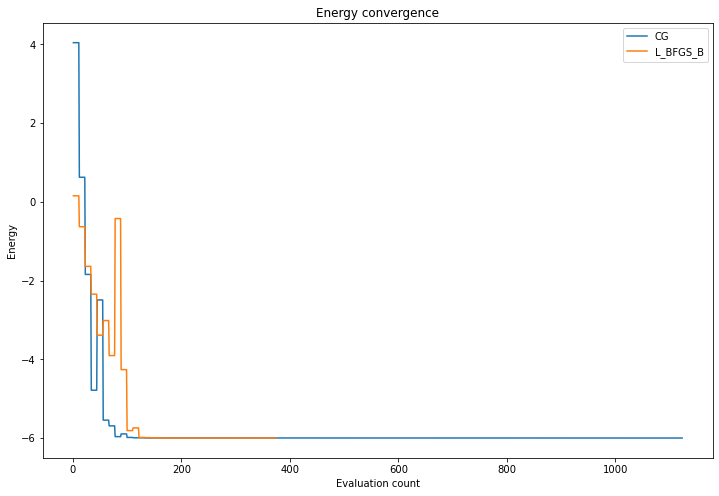

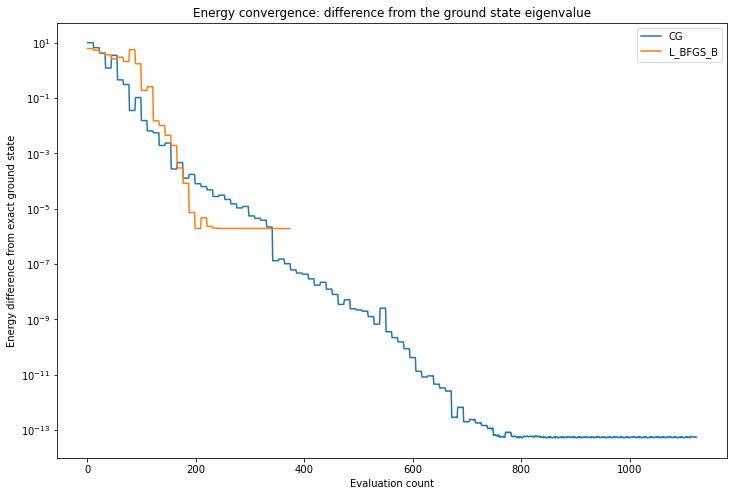

In [56]:
plt.figure(figsize=(12,8))
for i in range(len(optimizers)):
    plt.plot(converge_cnts[i], converge_vals[i], label=name_opt[i])
plt.xlabel("Evaluation count")
plt.ylabel("Energy")
plt.title("Energy convergence")
plt.legend(loc='upper right')

plt.figure(figsize=(12,8))
for i in range(len(optimizers)):
    plt.plot(converge_cnts[i], abs(ref - converge_vals[i]), label=name_opt[i])
plt.xlabel("Evaluation count")
plt.ylabel("Energy difference from exact ground state")
plt.title("Energy convergence: difference from the ground state eigenvalue")
plt.yscale("log")
plt.legend(loc='upper right')

### Cost function for total spin selection

We want to use the **find_minimum** algorithm of **VQE** function to find the eigenstates of total spin $\hat{S}$ by using the following cost function:

$$C(s_L,s_R,s_{LC},s,s_z) = \biggl( \langle \hat{S}_L^2 \rangle - s_L(s_L+1) \biggl)^2 + \biggl( \langle \hat{S}_R^2 \rangle - s_R(s_R+1) \biggl)^2 + \biggl( \langle \hat{S}_{LC}^2 \rangle - s_{LC}(s_{LC}+1) \biggl)^2 + \biggl( \langle \hat{S}^2 \rangle - s(s+1) \biggl)^2 + \biggl( \langle \hat{S}_z \rangle - s_z \biggl)^2$$

where the values inside the brackets are parameters which are used to select the total spin state we want to get (i.e. Barbara's classification)and the expectation values refer to the variational state which is created step by step during the optimization.

In [16]:
def spin_cost(v,l,r,lc,J,M):
    l2=l*(l+1)
    r2=r*(r+1)
    lc2=lc*(lc+1)
    J2=J*(J+1)
    op1=(np.dot(np.dot(np.conjugate(v),mat_sl2),v)-l2)**2
    op2=(np.dot(np.dot(np.conjugate(v),mat_sr2),v)-r2)**2
    op3=(np.dot(np.dot(np.conjugate(v),mat_slc2),v)-lc2)**2
    op4=(np.dot(np.dot(np.conjugate(v),mat_s2),v)-J2)**2
    op5=(np.dot(np.dot(np.conjugate(v),mat_sz),v)-M)**2
    return op1+op2+op3+op4+op5

#### Lowest energy states

In [17]:
lc,J=0.5,0.5
lab_list=[(0,0,lc,J,-J),(0,0,lc,J,J),(0,1,lc,J,-J),(0,1,lc,J,J),(1,0,lc,J,-J),(1,0,lc,J,J)]

min_val=[]
for l in lab_list:
    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        #circ=var_form.construct_circuit(x)       # To use with so4
        circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,l[0],l[1],l[2],l[3],l[4])
        return val

    min_val.append(algo.find_minimum(cost_fn=VQE_spin_cost,optimizer=CG(maxiter=70,gtol=1e-10)))

2021-02-19 10:12:00,247:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 1.07153956 -0.52981878  2.43987583  1.43790699  1.49224289 -2.34528068
  0.60287212 -0.79844681 -0.8824968  -0.82906625]
2021-02-19 10:12:00,250:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/py

In [20]:
mat_H2=np.dot(mat_H,mat_H)

for i,l in enumerate(lab_list):
    print("Ground state label: ",l)
    print("Optimal cost: ",min_val[i]['optimal_value'])
    best_circ=var_form.assign_parameters(min_val[i]['optimal_point'])        # To use with RealAmplitudes or TwoLocal
    best_psi=CircuitStateFn(best_circ).to_matrix()

    # Expected H and <H^2>-<H>^2
    E=np.real(np.dot(np.conjugate(np.transpose(best_psi)),np.dot(mat_H,best_psi)))
    E2=np.real(np.dot(np.conjugate(np.transpose(best_psi)),np.dot(mat_H2,best_psi)))
    print("<H> = ",E)
    print("<H^2> - <H>^2 = ",E2-E**2)

    # The best state
    print("|best state)=",to_ket(best_psi),"\n")

Ground state label:  (0, 0, 0.5, 0.5, -0.5)
Optimal cost:  7.742114139925735e-15
<H> =  -5.999999906492368
<H^2> - <H>^2 =  5.610458089222448e-07
|best state)=  + (-0.500+0.000j) |10110⟩ + (0.500+0.000j) |01110⟩ + (0.500+0.000j) |10101⟩ + (-0.500+0.000j) |01101⟩ 

Ground state label:  (0, 0, 0.5, 0.5, 0.5)
Optimal cost:  9.140755333579567e-15
<H> =  -5.999999966866975
<H^2> - <H>^2 =  1.9879860957416895e-07
|best state)=  + (-0.500+0.000j) |10010⟩ + (0.500+0.000j) |01010⟩ + (0.500+0.000j) |10001⟩ + (-0.500+0.000j) |01001⟩ 

Ground state label:  (0, 1, 0.5, 0.5, -0.5)
Optimal cost:  0.04865349323265537
<H> =  -5.7502104925096456
<H^2> - <H>^2 =  1.4363422468911509
|best state)=  + (0.110+0.000j) |10000⟩ + (-0.110+0.000j) |01000⟩ + (-0.067+0.000j) |10110⟩ + (0.067+0.000j) |01110⟩ + (-0.363+0.000j) |10101⟩ + (0.363+0.000j) |01101⟩ + (0.593+0.000j) |10011⟩ + (-0.593+0.000j) |01011⟩ 

Ground state label:  (0, 1, 0.5, 0.5, 0.5)
Optimal cost:  0.04865343327118174
<H> =  -5.750228561221968
<H^

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:343: DeprecationWarning: opt_params deprecated, use optimal_point property.
  warnings.warn('opt_params deprecated, use optimal_point property.',
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:343: DeprecationWarning: opt_params deprecated, use optimal_point property.
  warnings.warn('opt_params deprecated, use optimal_point property.',
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:343: DeprecationWarning: opt_params deprecated, use optimal_point property.
  warnings.warn('opt_params deprecated, use optimal_point property.',
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/qiskit/aqua/algorithms/vq_algorithm.py:343: DeprecationWarning: opt_params deprecated, use optimal_point property.
  warnings.warn('opt_params deprecated, use optimal_point property.',
/Users/Alecoal/opt/anaconda3/lib

#### Excited states with $E=0$

We now want to find the $8$ states which compose the subspace with energy $E=0$.

In [57]:
l,r,J=0,1,1.5
lab_list=[(l,r,0.5,J,-J),(l,r,0.5,J,-J+1),(l,r,0.5,J,J-1),(l,r,0.5,J,J),(r,l,J,J,-J),(r,l,J,J,-J+1),(r,l,J,J,J-1),(r,l,J,J,J)]

min_val=[]
for l in lab_list:
    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        #circ=var_form.construct_circuit(x)       # To use with so4
        circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,l[0],l[1],l[2],l[3],l[4])
        return val

    min_val.append(algo.find_minimum(cost_fn=VQE_spin_cost,optimizer=CG(maxiter=70,gtol=1e-10)))

2021-02-19 14:16:01,936:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 0.34326379  2.90867276  2.31280396  1.0480091  -2.12596668 -2.22772349
  0.75761215  0.29238349 -1.38774825  3.08964649]
2021-02-19 14:16:01,938:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/py

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values 

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_differentiable_functions.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x).astype(float)
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values 

In [58]:
for i,l in enumerate(lab_list):
    print("State label: ",l)
    print("Optimal cost: ",min_val[i]['optimal_value'])
    best_circ=var_form.assign_parameters(np.real(min_val[i]['optimal_point']))       # To use with RealAmplitudes or TwoLocal
    best_psi=CircuitStateFn(best_circ).to_matrix()

    # Expected H and <H^2>-<H>^2
    E=np.real(np.dot(np.conjugate(np.transpose(best_psi)),np.dot(mat_H,best_psi)))
    E2=np.real(np.dot(np.conjugate(np.transpose(best_psi)),np.dot(mat_H2,best_psi)))
    print("<H> = ",E)
    print("<H^2> - <H>^2 = ",E2-E**2)

    # The best state
    print("|best state)=",to_ket(best_psi),"\n")

State label:  (0, 1, 0.5, 1.5, -1.5)
Optimal cost:  5.691195626133209e-15
<H> =  -3.323754532105099e-08
<H^2> - <H>^2 =  3.9353123454460236e-07
|best state)=  + (-0.707+0.000j) |10111⟩ + (0.707+0.000j) |01111⟩ 

State label:  (0, 1, 0.5, 1.5, -0.5)
Optimal cost:  8.14028767834049e-09
<H> =  -5.964780278035122e-05
<H^2> - <H>^2 =  0.0017550912024427135
|best state)= (0.001+0.000j) |00000⟩ + (0.134+0.000j) |10000⟩ + (-0.132+0.000j) |01000⟩ + (0.191+0.000j) |10100⟩ + (-0.191+0.000j) |01100⟩ + (0.001+0.000j) |11100⟩ + (0.001+0.000j) |00010⟩ + (0.195+0.000j) |10010⟩ + (-0.194+0.000j) |01010⟩ + (0.001+0.000j) |11010⟩ + (0.272+0.000j) |10110⟩ + (-0.271+0.000j) |01110⟩ + (0.002+0.000j) |11110⟩ + (0.001+0.000j) |00001⟩ + (0.192+0.000j) |10001⟩ + (-0.190+0.000j) |01001⟩ + (0.001+0.000j) |11001⟩ + (0.275+0.000j) |10101⟩ + (-0.275+0.000j) |01101⟩ + (0.002+0.000j) |11101⟩ + (0.001+0.000j) |00011⟩ + (0.275+0.000j) |10011⟩ + (-0.274+0.000j) |01011⟩ + (0.001+0.000j) |11011⟩ + (0.383+0.000j) |10111⟩ + 

#### Excited states with $E=6$

We now want to find the $6$ states which compose the subspace with energy $E=6$.

In [59]:
l,r,lc,J=1,1,1.5,2.5
lab_list=[(l,r,lc,J,-J),(l,r,lc,J,-J+1),(l,r,lc,J,-J+2),(l,r,lc,J,J-2),(l,r,lc,J,J-1),(l,r,lc,J,J)]

min_val=[]
for l in lab_list:
    def VQE_spin_cost(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        #circ=var_form.construct_circuit(x)       # To use with so4
        circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost(circ_v,l[0],l[1],l[2],l[3],l[4])
        return val

    min_val.append(algo.find_minimum(cost_fn=VQE_spin_cost,optimizer=CG(maxiter=70,gtol=1e-10)))

2021-02-19 14:18:26,464:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 2.53864633  2.06853171  1.59885717  1.05207976  3.10654026  2.49277827
 -1.33526615 -0.90332722 -3.03330989  0.10086851]
2021-02-19 14:18:26,467:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2021-02-19 14:18:40,639:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592

2021-02-19 14:19:59,436:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,


In [60]:
for i,l in enumerate(lab_list):
    print("State label: ",l)
    print("Optimal cost: ",min_val[i]['optimal_value'])
    best_circ=var_form.assign_parameters(np.real(min_val[i]['optimal_point']))       # To use with RealAmplitudes or TwoLocal
    best_psi=CircuitStateFn(best_circ).to_matrix()

    # Expected H and <H^2>-<H>^2
    E=np.real(np.dot(np.conjugate(np.transpose(best_psi)),np.dot(mat_H,best_psi)))
    E2=np.real(np.dot(np.conjugate(np.transpose(best_psi)),np.dot(mat_H2,best_psi)))
    print("<H> = ",E)
    print("<H^2> - <H>^2 = ",E2-E**2)

    # The best state
    print("|best state)=",to_ket(best_psi),"\n")

State label:  (1, 1, 1.5, 2.5, -2.5)
Optimal cost:  1.99385025689896e-14
<H> =  5.999999859500547
<H^2> - <H>^2 =  1.391384621740599e-06
|best state)=  + (-1.000+0.000j) |11111⟩ 

State label:  (1, 1, 1.5, 2.5, -1.5)
Optimal cost:  2.1612497977829595e-12
<H> =  5.999998129195283
<H^2> - <H>^2 =  1.7963299285383982e-05
|best state)= (0.018+0.000j) |00000⟩ + (0.036+0.000j) |10000⟩ + (0.036+0.000j) |01000⟩ + (0.072+0.000j) |11000⟩ + (0.036+0.000j) |00100⟩ + (0.071+0.000j) |10100⟩ + (0.072+0.000j) |01100⟩ + (0.143+0.000j) |11100⟩ + (0.036+0.000j) |00010⟩ + (0.072+0.000j) |10010⟩ + (0.072+0.000j) |01010⟩ + (0.143+0.000j) |11010⟩ + (0.072+0.000j) |00110⟩ + (0.143+0.000j) |10110⟩ + (0.143+0.000j) |01110⟩ + (0.286+0.000j) |11110⟩ + (0.036+0.000j) |00001⟩ + (0.072+0.000j) |10001⟩ + (0.072+0.000j) |01001⟩ + (0.143+0.000j) |11001⟩ + (0.072+0.000j) |00101⟩ + (0.143+0.000j) |10101⟩ + (0.143+0.000j) |01101⟩ + (0.286+0.000j) |11101⟩ + (0.072+0.000j) |00011⟩ + (0.143+0.000j) |10011⟩ + (0.143+0.000j) |

#### Remaining excited states: $E=-4,-2,+2,+4$

Those states are the most entangled states - they all have configuration with $s_L=s_R=1$ - and they need a careful analysis. Indeed, those states don't have a particular value of the left-middle spin, $s_{LC}$, because they are built by linear combination of total spin states with $s_{LC}=1/2$ and $s_{LC}=3/2$. 

<img src="Pictures/CG_lab1.jpeg" width="500">
<img src="Pictures/CG_lab2.jpeg" width="500">

For this reason we need to change the "spin cost function" by just **removing the term with left-middle spin**.

$$C(s_L,s_R,s,s_z) = \biggl( \langle \hat{S}_L^2 \rangle - s_L(s_L+1) \biggl)^2 + \biggl( \langle \hat{S}_R^2 \rangle - s_R(s_R+1) \biggl)^2 + \biggl( \langle \hat{S}^2 \rangle - s(s+1) \biggl)^2 + \biggl( \langle \hat{S}_z \rangle - s_z \biggl)^2$$

The main consequence of this reasoning is that we can just look for states with $E=-4$ and $E=-2$ because states with $E=4$ and $E=2$ have the same values of left, right and total spin of the two above, respectively. 

In [61]:
def spin_cost_ent(v,l,r,J,M):
    l2=l*(l+1)
    r2=r*(r+1)
    J2=J*(J+1)
    op1=(np.dot(np.dot(np.conjugate(v),mat_sl2),v)-l2)**2
    op2=(np.dot(np.dot(np.conjugate(v),mat_sr2),v)-r2)**2
    op4=(np.dot(np.dot(np.conjugate(v),mat_s2),v)-J2)**2
    op5=(np.dot(np.dot(np.conjugate(v),mat_sz),v)-M)**2
    return op1+op2+op4+op5

#### Excited states with $E=-4$

In [62]:
l,r,J=1,1,1.5
lab_list=[(l,r,J,-J),(l,r,J,-J+1),(l,r,J,J-1),(l,r,J,J)]

min_val=[]
for l in lab_list:
    def VQE_spin_cost_ent(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        #circ=var_form.construct_circuit(x)       # To use with so4
        circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost_ent(circ_v,l[0],l[1],l[2],l[3])
        return val

    min_val.append(algo.find_minimum(cost_fn=VQE_spin_cost_ent,optimizer=CG(maxiter=70,gtol=1e-10)))

2021-02-19 14:20:25,520:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 3.08278787 -2.49677762 -1.36831455 -2.78083609 -2.44827682 -1.0944685
  2.44497193 -1.85647366  0.51278718 -1.10292656]
2021-02-19 14:20:25,522:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2021-02-19 14:20:41,284:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.1415926

In [63]:
for i,l in enumerate(lab_list):
    print("State label: ",l)
    print("Optimal cost: ",min_val[i]['optimal_value'])
    best_circ=var_form.assign_parameters(np.real(min_val[i]['optimal_point']))       # To use with RealAmplitudes or TwoLocal
    best_psi=CircuitStateFn(best_circ).to_matrix()

    # Expected H and <H^2>-<H>^2
    E=np.real(np.dot(np.conjugate(np.transpose(best_psi)),np.dot(mat_H,best_psi)))
    E2=np.real(np.dot(np.conjugate(np.transpose(best_psi)),np.dot(mat_H2,best_psi)))
    print("<H> = ",E)
    print("<H^2> - <H>^2 = ",E2-E**2)

    # The best state
    print("|best state)=",to_ket(best_psi),"\n")

State label:  (1, 1, 1.5, -1.5)
Optimal cost:  0.01280888193818764
<H> =  -3.192372620836465
<H^2> - <H>^2 =  5.164856364248509
|best state)= (0.002+0.000j) |00000⟩ + (0.007+0.000j) |10000⟩ + (-0.002+0.000j) |01000⟩ + (-0.015+0.000j) |11000⟩ + (0.002+0.000j) |10100⟩ + (-0.004+0.000j) |01100⟩ + (-0.033+0.000j) |11100⟩ + (0.007+0.000j) |00010⟩ + (0.015+0.000j) |10010⟩ + (0.016+0.000j) |01010⟩ + (0.118+0.000j) |11010⟩ + (-0.011+0.000j) |00110⟩ + (-0.030+0.000j) |10110⟩ + (-0.001+0.000j) |01110⟩ + (-0.002+0.000j) |11110⟩ + (-0.013+0.000j) |00001⟩ + (-0.041+0.000j) |10001⟩ + (0.015+0.000j) |01001⟩ + (0.118+0.000j) |11001⟩ + (-0.005+0.000j) |00101⟩ + (-0.022+0.000j) |10101⟩ + (0.028+0.000j) |01101⟩ + (0.219+0.000j) |11101⟩ + (-0.051+0.000j) |00011⟩ + (-0.113+0.000j) |10011⟩ + (-0.120+0.000j) |01011⟩ + (-0.910+0.000j) |11011⟩ + (0.082+0.000j) |00111⟩ + (0.230+0.000j) |10111⟩ + (0.004+0.000j) |01111⟩ + (0.010+0.000j) |11111⟩ 

State label:  (1, 1, 1.5, -0.5)
Optimal cost:  3.0361661827238857e-

#### Excited states with $E=-2$

In [64]:
l,r,J=1,1,0.5
lab_list=[(l,r,J,-J),(l,r,J,J)]

min_val=[]
for l in lab_list:
    def VQE_spin_cost_ent(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        #circ=var_form.construct_circuit(x)       # To use with so4
        circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost_ent(circ_v,l[0],l[1],l[2],l[3])
        return val

    min_val.append(algo.find_minimum(cost_fn=VQE_spin_cost_ent,optimizer=CG(maxiter=70,gtol=1e-10)))

2021-02-19 14:21:38,593:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 0.25826035 -2.11942292 -0.52261284  1.40073545  0.59846165  1.96635617
 -1.51246729  2.22545876  1.71404935  1.69889919]
2021-02-19 14:21:38,596:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2021-02-19 14:21:57,355:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592

In [65]:
for i,l in enumerate(lab_list):
    print("State label: ",l)
    print("Optimal cost: ",min_val[i]['optimal_value'])
    best_circ=var_form.assign_parameters(np.real(min_val[i]['optimal_point']))       # To use with RealAmplitudes or TwoLocal
    best_psi=CircuitStateFn(best_circ).to_matrix()

    # Expected H and <H^2>-<H>^2
    E=np.real(np.dot(np.conjugate(np.transpose(best_psi)),np.dot(mat_H,best_psi)))
    E2=np.real(np.dot(np.conjugate(np.transpose(best_psi)),np.dot(mat_H2,best_psi)))
    print("<H> = ",E)
    print("<H^2> - <H>^2 = ",E2-E**2)

    # The best state
    print("|best state)=",to_ket(best_psi),"\n")

State label:  (1, 1, 0.5, -0.5)
Optimal cost:  0.9968132838513019
<H> =  -2.3090104975107737
<H^2> - <H>^2 =  9.853235782144573
|best state)=  + (-0.002+0.000j) |10000⟩ + (0.003+0.000j) |01000⟩ + (-0.008+0.000j) |11000⟩ + (-0.001+0.000j) |00100⟩ + (0.236+0.000j) |10100⟩ + (-0.226+0.000j) |01100⟩ + (0.705+0.000j) |11100⟩ + (-0.001+0.000j) |00010⟩ + (-0.181+0.000j) |10010⟩ + (0.183+0.000j) |01010⟩ + (-0.571+0.000j) |11010⟩ + (-0.001+0.000j) |10110⟩ + (-0.002+0.000j) |11110⟩ + (-0.011+0.000j) |10001⟩ + (0.012+0.000j) |01001⟩ + (-0.036+0.000j) |11001⟩ + (0.001+0.000j) |11101⟩ + (0.002+0.000j) |10011⟩ + (-0.002+0.000j) |01011⟩ + (0.006+0.000j) |11011⟩ + (0.015+0.000j) |10111⟩ + (-0.014+0.000j) |01111⟩ + (0.045+0.000j) |11111⟩ 

State label:  (1, 1, 0.5, 0.5)
Optimal cost:  0.996913200447417
<H> =  -2.298062411701025
<H^2> - <H>^2 =  9.899273576930568
|best state)= (-0.045+0.000j) |00000⟩ + (0.015+0.000j) |10000⟩ + (-0.014+0.000j) |01000⟩ + (0.008+0.000j) |00100⟩ + (-0.003+0.000j) |10100⟩ + 

**Question** We notice that energy is less than $-2$. Is there something wrong in the line of reasoning?

### Starting the VQE  from one of the Clebsh-Gordan states 

#### Excited states with energy $E=-4$

We wonder if the algorithm gets better results by starting from an initial state taken from the Clebsh-Gordan states in the case of eigenstates of $H$ which can be described by linear combination of excited states. We will use again the **RY** variational form. 

We start from creating all the Clebsh-Gordan states.

In [45]:
psi_L   = compose_two_spins('L')
psi_R   = compose_two_spins('R')
psi_LC  = compose_with_center(psi_L,'L')
psi_LCR = compose_with_right(psi_LC,psi_R)

psi=[]
for v in psi_LCR.values():
    # We use concatenate 4 times because the vectors have been built using np.zeros((2,2,2,2,2))
    psi.append(np.concatenate(np.concatenate(np.concatenate(np.concatenate(v)))))

We initialize the VQE algorithm starting from the Clebsh-Gordan state: $| s_L=1,s_R=1,s_{LC}=1/2,s=3/2,s_z=-3/2\rangle$.

In [49]:
# Definition of the initial state 
psi_c=Custom(nqubit,state_vector=psi[12])

#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(H.num_qubits,entanglement=nn_list,initial_state=psi_c,insert_barriers=True,reps=1)
#print("Number of parameters: "+str(var_form.num_parameters))

#print(var_form.draw())

In [50]:
optimizers=[CG(maxiter=50,gtol=1e-07),L_BFGS_B(maxiter=10000,epsilon=1e-12)]
name_opt=["CG","L_BFGS_B"]

converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print('Optimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
  
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    algo = VQE(H, var_form, optimizer, callback=store_intermediate_result)   #,aux_operators=A_op)
    algo_result      = algo.run(quantum_instance_1)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
    for k in algo_result:
        print(k,algo_result[k])

2021-02-19 13:57:54,034:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  IIIXX,
  IIIYY,
  IIIZZ,
  IIXXI,
  IIYYI,
  IIZZI,
  IIXIX,
  IIYIY,
  IIZIZ,
  IXXII,
  IYYII,
  IZZII,
  XIXII,
  YIYII,
  ZIZII,
  XXIII,
  YYIII,
  ZZIII
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7f9a4ee48880>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7f9a4ed28820>>
-- initial_point: Random seed
-- var_form:           ┌───────────────────┐                           »
q_0: ─────┤ U3(3π/16,0.0,0.0) ├───────────────────────────»
          └┬──────────────────┤                           »
q_1: ──────┤ U3(3π/8,0.0

2021-02-19 13:57:54,038:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 1.32264321  1.55660442  2.17874532  0.64392248 -2.27481357 -1.50241062
 -0.50401493  0.71905281  0.50768233  0.39167973]
2021-02-19 13:57:54,039:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2021-02-19 13:57:54,094:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====


Optimizer: CG        

2021-02-19 13:57:54,097:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 130 operations with depth 118
op_counts: OrderedDict([('u', 62), ('cx', 58), ('ry', 10), ('barrier', 2)])

2021-02-19 13:57:54,102:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2021-02-19 13:57:54,106:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 130 operations with depth 118
op_counts: OrderedDict([('u', 62), ('cx', 58), ('ry', 10), ('barrier', 2)])

2021-02-19 13:57:54,112:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.50587 (ms)
2021-02-19 13:57:54,130:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-0.47314428] - 58.59828 (ms), eval count: 1
2021-02-19 13:57:54,132:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.09506 (ms)
2021-02-19 13:57:54,138:qiskit.aqua.algorithms.minimum_eigen_so

2021-02-19 13:57:54,429:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.11914 (ms)
2021-02-19 13:57:54,436:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.53396599] - 7.94196 (ms), eval count: 29
2021-02-19 13:57:54,441:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18494 (ms)
2021-02-19 13:57:54,447:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.533966] - 7.56693 (ms), eval count: 30
2021-02-19 13:57:54,454:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19233 (ms)
2021-02-19 13:57:54,462:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.53396602] - 8.76522 (ms), eval count: 31
2021-02-19 13:57:54,471:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.09207 (ms)
2021-02-19 13:57:54,485:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluat

2021-02-19 13:57:54,859:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15299 (ms)
2021-02-19 13:57:54,866:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.74976128] - 8.75092 (ms), eval count: 60
2021-02-19 13:57:54,870:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90783 (ms)
2021-02-19 13:57:54,880:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.74976129] - 12.35008 (ms), eval count: 61
2021-02-19 13:57:54,885:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.71900 (ms)
2021-02-19 13:57:54,892:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-3.7497613] - 8.81314 (ms), eval count: 62
2021-02-19 13:57:54,896:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.69961 (ms)
2021-02-19 13:57:54,902:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-02-19 13:57:55,278:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.46627 (ms)
2021-02-19 13:57:55,291:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.03409003] - 14.01615 (ms), eval count: 91
2021-02-19 13:57:55,295:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20282 (ms)
2021-02-19 13:57:55,308:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.03409004] - 13.84282 (ms), eval count: 92
2021-02-19 13:57:55,311:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.30081 (ms)
2021-02-19 13:57:55,319:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.03409003] - 9.32622 (ms), eval count: 93
2021-02-19 13:57:55,324:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.35217 (ms)
2021-02-19 13:57:55,336:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-02-19 13:57:55,809:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.28579 (ms)
2021-02-19 13:57:55,823:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.71325474] - 14.80508 (ms), eval count: 122
2021-02-19 13:57:55,828:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.82907 (ms)
2021-02-19 13:57:55,837:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.71325473] - 11.95383 (ms), eval count: 123
2021-02-19 13:57:55,840:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.36375 (ms)
2021-02-19 13:57:55,850:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.71325473] - 10.55193 (ms), eval count: 124
2021-02-19 13:57:55,852:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.41716 (ms)
2021-02-19 13:57:55,861:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2021-02-19 13:57:56,321:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 9.11689 (ms)
2021-02-19 13:57:56,330:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.83524433] - 18.29004 (ms), eval count: 153
2021-02-19 13:57:56,344:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.48296 (ms)
2021-02-19 13:57:56,358:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.83524432] - 15.13004 (ms), eval count: 154
2021-02-19 13:57:56,364:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.31323 (ms)
2021-02-19 13:57:56,381:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96078646] - 20.53905 (ms), eval count: 155
2021-02-19 13:57:56,388:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.53208 (ms)
2021-02-19 13:57:56,400:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2021-02-19 13:57:56,876:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19710 (ms)
2021-02-19 13:57:56,889:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98607929] - 14.33778 (ms), eval count: 184
2021-02-19 13:57:56,894:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20020 (ms)
2021-02-19 13:57:56,903:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98607929] - 9.74226 (ms), eval count: 185
2021-02-19 13:57:56,908:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.25012 (ms)
2021-02-19 13:57:56,919:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98607929] - 13.71074 (ms), eval count: 186
2021-02-19 13:57:56,921:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14894 (ms)
2021-02-19 13:57:56,938:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2021-02-19 13:57:57,336:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14107 (ms)
2021-02-19 13:57:57,345:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99654432] - 10.45299 (ms), eval count: 215
2021-02-19 13:57:57,350:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.08084 (ms)
2021-02-19 13:57:57,360:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99654432] - 12.92610 (ms), eval count: 216
2021-02-19 13:57:57,367:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.72100 (ms)
2021-02-19 13:57:57,385:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99654432] - 21.45600 (ms), eval count: 217
2021-02-19 13:57:57,391:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.32823 (ms)
2021-02-19 13:57:57,406:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2021-02-19 13:57:57,834:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18780 (ms)
2021-02-19 13:57:57,841:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99992943] - 8.74186 (ms), eval count: 246
2021-02-19 13:57:57,845:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.12796 (ms)
2021-02-19 13:57:57,851:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99992943] - 7.20477 (ms), eval count: 247
2021-02-19 13:57:57,856:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.43194 (ms)
2021-02-19 13:57:57,865:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99992943] - 10.19311 (ms), eval count: 248
2021-02-19 13:57:57,869:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.53089 (ms)
2021-02-19 13:57:57,875:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2021-02-19 13:57:58,291:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13392 (ms)
2021-02-19 13:57:58,302:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999723] - 12.26497 (ms), eval count: 277
2021-02-19 13:57:58,312:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.51491 (ms)
2021-02-19 13:57:58,330:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999723] - 19.42897 (ms), eval count: 278
2021-02-19 13:57:58,338:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.96006 (ms)
2021-02-19 13:57:58,348:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999723] - 14.97388 (ms), eval count: 279
2021-02-19 13:57:58,356:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40285 (ms)
2021-02-19 13:57:58,365:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2021-02-19 13:57:58,741:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.13814 (ms)
2021-02-19 13:57:58,749:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999921] - 9.77397 (ms), eval count: 308
2021-02-19 13:57:58,753:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.33491 (ms)
2021-02-19 13:57:58,766:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999758] - 14.23097 (ms), eval count: 309
2021-02-19 13:57:58,772:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.95226 (ms)
2021-02-19 13:57:58,779:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999758] - 11.06501 (ms), eval count: 310
2021-02-19 13:57:58,785:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.74713 (ms)
2021-02-19 13:57:58,793:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2021-02-19 13:57:59,358:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16205 (ms)
2021-02-19 13:57:59,370:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999963] - 12.60781 (ms), eval count: 339
2021-02-19 13:57:59,372:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.11413 (ms)
2021-02-19 13:57:59,386:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999963] - 15.02204 (ms), eval count: 340
2021-02-19 13:57:59,391:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.10912 (ms)
2021-02-19 13:57:59,403:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999963] - 13.28707 (ms), eval count: 341
2021-02-19 13:57:59,408:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.84791 (ms)
2021-02-19 13:57:59,427:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2021-02-19 13:57:59,856:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.47510 (ms)
2021-02-19 13:57:59,865:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 10.34284 (ms), eval count: 370
2021-02-19 13:57:59,869:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.72012 (ms)
2021-02-19 13:57:59,878:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 10.86092 (ms), eval count: 371
2021-02-19 13:57:59,880:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16014 (ms)
2021-02-19 13:57:59,888:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999998] - 9.42016 (ms), eval count: 372
2021-02-19 13:57:59,892:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.12700 (ms)
2021-02-19 13:57:59,900:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2021-02-19 13:58:00,344:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.13313 (ms)
2021-02-19 13:58:00,357:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 15.27119 (ms), eval count: 401
2021-02-19 13:58:00,360:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.34103 (ms)
2021-02-19 13:58:00,370:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.82270 (ms), eval count: 402
2021-02-19 13:58:00,375:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13010 (ms)
2021-02-19 13:58:00,389:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.87899 (ms), eval count: 403
2021-02-19 13:58:00,394:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.71781 (ms)
2021-02-19 13:58:00,407:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2021-02-19 13:58:00,943:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.11811 (ms)
2021-02-19 13:58:00,957:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 16.02101 (ms), eval count: 433
2021-02-19 13:58:00,964:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.36933 (ms)
2021-02-19 13:58:00,978:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 17.65895 (ms), eval count: 434
2021-02-19 13:58:00,991:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 6.21915 (ms)
2021-02-19 13:58:01,002:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 17.31992 (ms), eval count: 435
2021-02-19 13:58:01,009:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.59709 (ms)
2021-02-19 13:58:01,026:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2021-02-19 13:58:01,598:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.44100 (ms)
2021-02-19 13:58:01,610:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.32593 (ms), eval count: 465
2021-02-19 13:58:01,614:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.26974 (ms)
2021-02-19 13:58:01,621:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.17101 (ms), eval count: 466
2021-02-19 13:58:01,625:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.17700 (ms)
2021-02-19 13:58:01,632:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.08797 (ms), eval count: 467
2021-02-19 13:58:01,638:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05374 (ms)
2021-02-19 13:58:01,648:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.

2021-02-19 13:58:02,124:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15609 (ms)
2021-02-19 13:58:02,130:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.86185 (ms), eval count: 497
2021-02-19 13:58:02,135:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.66297 (ms)
2021-02-19 13:58:02,142:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.43899 (ms), eval count: 498
2021-02-19 13:58:02,147:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.93691 (ms)
2021-02-19 13:58:02,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.78393 (ms), eval count: 499
2021-02-19 13:58:02,162:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.60592 (ms)
2021-02-19 13:58:02,170:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.]

2021-02-19 13:58:02,698:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.03602 (ms)
2021-02-19 13:58:02,709:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.15825 (ms), eval count: 529
2021-02-19 13:58:02,712:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19686 (ms)
2021-02-19 13:58:02,720:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.77595 (ms), eval count: 530
2021-02-19 13:58:02,725:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.03602 (ms)
2021-02-19 13:58:02,735:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.55178 (ms), eval count: 531
2021-02-19 13:58:02,737:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19925 (ms)
2021-02-19 13:58:02,746:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.

2021-02-19 13:58:03,330:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24407 (ms)
2021-02-19 13:58:03,343:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.33301 (ms), eval count: 561
2021-02-19 13:58:03,348:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.47605 (ms)
2021-02-19 13:58:03,361:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.95297 (ms), eval count: 562
2021-02-19 13:58:03,363:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14584 (ms)
2021-02-19 13:58:03,372:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.15711 (ms), eval count: 563
2021-02-19 13:58:03,374:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.66893 (ms)
2021-02-19 13:58:03,382:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2021-02-19 13:58:03,853:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.00479 (ms)
2021-02-19 13:58:03,864:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.96489 (ms), eval count: 593
2021-02-19 13:58:03,867:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99032 (ms)
2021-02-19 13:58:03,880:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.72688 (ms), eval count: 594
2021-02-19 13:58:03,884:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Optimization complete in 9.845653057098389 seconds.
Found opt_params [ 1.57079629e+00 -2.85654440e-08  2.11851118e+00  2.01181233e+00
 -5.82065633e-01 -1.23665077e+00 -1.23665077e+00  1.83580305e+00
 -4.91956171e-01  7.41443719e-01] in 594 evals


optimal_parameters {Parameter(θ[0]): 1.5707962948204426, Parameter(θ[1]): -2.856544404609384e-08, Parameter(θ[2]): 2.118511182968867, Parameter(θ[3]): 2.011812328024575, Parameter(θ[4]): -0.5820656329904123, Parameter(θ[5]): -1.236650770511328, Parameter(θ[6]): -1.2366507745647426, Parameter(θ[7]): 1.8358030488352917, Parameter(θ[8]): -0.49195617127299174, Parameter(θ[9]): 0.7414437194472508}
optimal_point [ 1.57079629e+00 -2.85654440e-08  2.11851118e+00  2.01181233e+00
 -5.82065633e-01 -1.23665077e+00 -1.23665077e+00  1.83580305e+00
 -4.91956171e-01  7.41443719e-01]
optimal_value -5.999999999999984
optimizer_evals 594
optimizer_time 9.845653057098389
eigenvalue (-5.999999999999984+0j)
eigenstate [-1.15970206e-09+4.70971825e-18j -6.74638837e-09-1.79920316e-17j
  1.34274034e-08+6.09713064e-18j  1.15970214e-09+2.17289934e-17j
 -3.18210617e-09-1.17082724e-17j -2.44527059e-01+3.63537302e-17j
  2.44527057e-01-2.66362134e-17j  4.17327571e-09-2.70706991e-17j
 -3.25085552e-09-5.93736612e-18j -

2021-02-19 13:58:04,176:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  IIIXX,
  IIIYY,
  IIIZZ,
  IIXXI,
  IIYYI,
  IIZZI,
  IIXIX,
  IIYIY,
  IIZIZ,
  IXXII,
  IYYII,
  IZZII,
  XIXII,
  YIYII,
  ZIZII,
  XXIII,
  YYIII,
  ZZIII
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.l_bfgs_b.L_BFGS_B object at 0x7f9a4ee48040>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7f9a4eb2a2b0>>
-- initial_point: Random seed
-- var_form:           ┌───────────────────┐                           »
q_0: ─────┤ U3(3π/16,0.0,0.0) ├───────────────────────────»
          └┬──────────────────┤                           »
q_1: ──────┤

2021-02-19 13:58:04,178:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-0.33740554  1.56187257  0.03493021 -2.81889815 -1.40540552  0.89015261
 -3.04433184  1.41589024  1.62754627 -2.39600721]
2021-02-19 13:58:04,229:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2021-02-19 13:58:04,236:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 130 operations with depth 118
op_counts: OrderedDict([('u', 62), ('cx', 58), ('ry', 10), ('barrier', 2)])

2021-02-19 13:58:04,243:qiskit.aqua.

2021-02-19 13:58:04,675:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.27475 (ms)
2021-02-19 13:58:04,689:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.62424377] - 16.61587 (ms), eval count: 26
2021-02-19 13:58:04,693:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.00987 (ms)
2021-02-19 13:58:04,700:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.62424377] - 9.02605 (ms), eval count: 27
2021-02-19 13:58:04,710:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.61099 (ms)
2021-02-19 13:58:04,720:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.62424377] - 12.02798 (ms), eval count: 28
2021-02-19 13:58:04,725:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.12526 (ms)
2021-02-19 13:58:04,739:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eva

2021-02-19 13:58:05,186:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.76899 (ms)
2021-02-19 13:58:05,199:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17148837] - 16.07299 (ms), eval count: 57
2021-02-19 13:58:05,212:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.58787 (ms)
2021-02-19 13:58:05,223:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17148837] - 11.83915 (ms), eval count: 58
2021-02-19 13:58:05,231:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.49894 (ms)
2021-02-19 13:58:05,242:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.17148837] - 13.24487 (ms), eval count: 59
2021-02-19 13:58:05,246:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15800 (ms)
2021-02-19 13:58:05,255:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

2021-02-19 13:58:05,730:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15418 (ms)
2021-02-19 13:58:05,740:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.97386647] - 11.16800 (ms), eval count: 88
2021-02-19 13:58:05,747:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.78091 (ms)
2021-02-19 13:58:05,759:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9958674] - 13.85593 (ms), eval count: 89
2021-02-19 13:58:05,763:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02703 (ms)
2021-02-19 13:58:05,778:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9958674] - 17.50207 (ms), eval count: 90
2021-02-19 13:58:05,782:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10810 (ms)
2021-02-19 13:58:05,798:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-02-19 13:58:06,261:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.19314 (ms)
2021-02-19 13:58:06,275:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99955951] - 17.47608 (ms), eval count: 119
2021-02-19 13:58:06,283:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.91085 (ms)
2021-02-19 13:58:06,298:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99955951] - 18.18609 (ms), eval count: 120
2021-02-19 13:58:06,309:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 8.35395 (ms)
2021-02-19 13:58:06,330:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99955951] - 28.59497 (ms), eval count: 121
2021-02-19 13:58:06,337:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.32301 (ms)
2021-02-19 13:58:06,349:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2021-02-19 13:58:06,967:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.11175 (ms)
2021-02-19 13:58:06,979:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99996081] - 12.89487 (ms), eval count: 150
2021-02-19 13:58:06,983:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.26696 (ms)
2021-02-19 13:58:06,995:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99996081] - 13.32498 (ms), eval count: 151
2021-02-19 13:58:07,000:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.55711 (ms)
2021-02-19 13:58:07,013:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99996081] - 14.76002 (ms), eval count: 152
2021-02-19 13:58:07,016:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.43170 (ms)
2021-02-19 13:58:07,028:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2021-02-19 13:58:07,493:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.67291 (ms)
2021-02-19 13:58:07,506:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998876] - 18.65816 (ms), eval count: 181
2021-02-19 13:58:07,515:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13583 (ms)
2021-02-19 13:58:07,523:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998876] - 9.45473 (ms), eval count: 182
2021-02-19 13:58:07,532:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.11510 (ms)
2021-02-19 13:58:07,544:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998876] - 16.30020 (ms), eval count: 183
2021-02-19 13:58:07,548:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21021 (ms)
2021-02-19 13:58:07,558:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy 

2021-02-19 13:58:08,029:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.38712 (ms)
2021-02-19 13:58:08,040:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999978] - 12.92205 (ms), eval count: 212
2021-02-19 13:58:08,044:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39117 (ms)
2021-02-19 13:58:08,052:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999978] - 9.70387 (ms), eval count: 213
2021-02-19 13:58:08,054:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15728 (ms)
2021-02-19 13:58:08,061:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999978] - 7.72882 (ms), eval count: 214
2021-02-19 13:58:08,064:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.06923 (ms)
2021-02-19 13:58:08,077:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2021-02-19 13:58:08,467:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.73402 (ms)
2021-02-19 13:58:08,476:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.999917] - 10.97178 (ms), eval count: 243
2021-02-19 13:58:08,480:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.30415 (ms)
2021-02-19 13:58:08,495:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.999917] - 16.03198 (ms), eval count: 244
2021-02-19 13:58:08,498:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.39611 (ms)
2021-02-19 13:58:08,508:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.999917] - 11.60097 (ms), eval count: 245
2021-02-19 13:58:08,511:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.76716 (ms)
2021-02-19 13:58:08,519:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evalu

2021-02-19 13:58:08,925:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.11985 (ms)
2021-02-19 13:58:08,934:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999975] - 10.75006 (ms), eval count: 274
2021-02-19 13:58:08,940:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.99518 (ms)
2021-02-19 13:58:08,947:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999975] - 10.86712 (ms), eval count: 275
2021-02-19 13:58:08,951:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.03872 (ms)
2021-02-19 13:58:08,962:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999981] - 13.27634 (ms), eval count: 276
2021-02-19 13:58:08,968:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94209 (ms)
2021-02-19 13:58:08,979:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2021-02-19 13:58:09,389:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.83320 (ms)
2021-02-19 13:58:09,397:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99992307] - 10.37979 (ms), eval count: 305
2021-02-19 13:58:09,400:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16897 (ms)
2021-02-19 13:58:09,415:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99992307] - 16.17384 (ms), eval count: 306
2021-02-19 13:58:09,418:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19996 (ms)
2021-02-19 13:58:09,429:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99992307] - 12.36510 (ms), eval count: 307
2021-02-19 13:58:09,431:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23405 (ms)
2021-02-19 13:58:09,438:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2021-02-19 13:58:09,804:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.74022 (ms)
2021-02-19 13:58:09,811:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999998] - 8.78596 (ms), eval count: 336
2021-02-19 13:58:09,816:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.89805 (ms)
2021-02-19 13:58:09,825:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999998] - 11.13987 (ms), eval count: 337
2021-02-19 13:58:09,828:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.69277 (ms)
2021-02-19 13:58:09,835:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999998] - 8.57711 (ms), eval count: 338
2021-02-19 13:58:09,839:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.94383 (ms)
2021-02-19 13:58:09,845:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy eval

2021-02-19 13:58:10,254:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.13408 (ms)
2021-02-19 13:58:10,269:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 17.75599 (ms), eval count: 367
2021-02-19 13:58:10,273:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.24216 (ms)
2021-02-19 13:58:10,282:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 10.28395 (ms), eval count: 368
2021-02-19 13:58:10,288:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.55196 (ms)
2021-02-19 13:58:10,295:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 10.25105 (ms), eval count: 369
2021-02-19 13:58:10,299:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.34587 (ms)
2021-02-19 13:58:10,311:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2021-02-19 13:58:10,667:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.15800 (ms)
2021-02-19 13:58:10,675:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 9.23109 (ms), eval count: 398
2021-02-19 13:58:10,681:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.91021 (ms)
2021-02-19 13:58:10,693:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 13.37004 (ms), eval count: 399
2021-02-19 13:58:10,695:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.17707 (ms)
2021-02-19 13:58:10,702:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 8.23689 (ms), eval count: 400
2021-02-19 13:58:10,707:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.64032 (ms)
2021-02-19 13:58:10,713:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2021-02-19 13:58:11,061:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.78909 (ms)
2021-02-19 13:58:11,084:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 24.90783 (ms), eval count: 429
2021-02-19 13:58:11,089:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.57199 (ms)
2021-02-19 13:58:11,104:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 17.93218 (ms), eval count: 430
2021-02-19 13:58:11,118:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.27492 (ms)
2021-02-19 13:58:11,143:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 28.70297 (ms), eval count: 431
2021-02-19 13:58:11,146:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.27625 (ms)
2021-02-19 13:58:11,152:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy

2021-02-19 13:58:11,501:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19090 (ms)
2021-02-19 13:58:11,509:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 9.70387 (ms), eval count: 460
2021-02-19 13:58:11,513:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.82796 (ms)
2021-02-19 13:58:11,519:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 8.61406 (ms), eval count: 461
2021-02-19 13:58:11,522:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.59788 (ms)
2021-02-19 13:58:11,530:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 9.91106 (ms), eval count: 462
2021-02-19 13:58:11,535:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.10118 (ms)
2021-02-19 13:58:11,542:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy ev

optimal_parameters {Parameter(θ[0]): -1.5705544337808903, Parameter(θ[1]): 3.141592653589793, Parameter(θ[2]): 0.8610037651409115, Parameter(θ[3]): -1.959645297861505, Parameter(θ[4]): -2.669475882638883, Parameter(θ[5]): 0.597227897162662, Parameter(θ[6]): -2.5443451709860083, Parameter(θ[7]): 0.2819597306601432, Parameter(θ[8]): 2.1670906665347083, Parameter(θ[9]): -1.9664955383016602}
optimal_point [-1.57055443  3.14159265  0.86100377 -1.9596453  -2.66947588  0.5972279
 -2.54434517  0.28195973  2.16709067 -1.96649554]
optimal_value -5.999999820524009
optimizer_evals 473
optimizer_time 7.50478982925415
eigenvalue (-5.999999820524009+0j)
eigenstate [ 1.00217421e-09+2.33055287e-18j -1.72144610e-05+6.62570993e-18j
  1.72110182e-05-2.04156283e-17j -1.33929327e-09-2.67327912e-18j
 -7.39013748e-07+1.32253168e-17j  1.26941240e-02+1.00695606e-17j
 -1.26915852e-02-1.23198006e-17j  9.87608905e-07+2.06337540e-17j
 -1.61024421e-05-2.29422047e-17j  2.76593498e-01-5.17192808e-17j
 -2.76538179e-01+

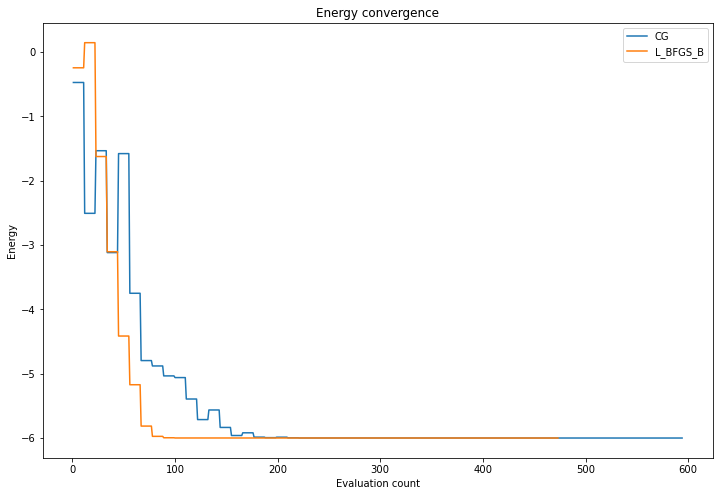

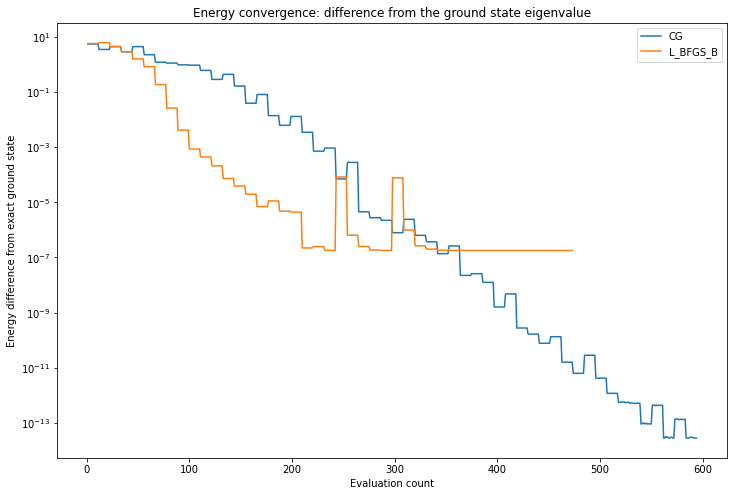

In [51]:
plt.figure(figsize=(12,8))
for i in range(len(optimizers)):
    plt.plot(converge_cnts[i], converge_vals[i], label=name_opt[i])
plt.xlabel("Evaluation count")
plt.ylabel("Energy")
plt.title("Energy convergence")
plt.legend(loc='upper right')

plt.figure(figsize=(12,8))
for i in range(len(optimizers)):
    plt.plot(converge_cnts[i], abs(ref - converge_vals[i]), label=name_opt[i])
plt.xlabel("Evaluation count")
plt.ylabel("Energy difference from exact ground state")
plt.title("Energy convergence: difference from the ground state eigenvalue")
plt.yscale("log")
plt.legend(loc='upper right')

Now we use the **find_minimum** method of **VQE**.

In [52]:
l,r,J=1,1,1.5
lab_list=[(l,r,J,-J),(l,r,J,-J+1),(l,r,J,J-1),(l,r,J,J)]

min_val=[]
for l in lab_list:
    def VQE_spin_cost_ent(x):
        # Here we convert the circuit corresponding to the variational state into a vector
        #circ=var_form.construct_circuit(x)       # To use with so4
        circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
        circ_v=CircuitStateFn(circ).to_matrix()
        #print(circ_v)

        val=spin_cost_ent(circ_v,l[0],l[1],l[2],l[3])
        return val

    min_val.append(algo.find_minimum(cost_fn=VQE_spin_cost_ent,optimizer=CG(maxiter=70,gtol=1e-10)))

2021-02-19 13:59:32,351:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-2.27637506 -2.01521009 -1.57468261  1.26895564 -0.67528901  2.91047104
  1.24306962  0.67769828 -1.18782374  0.0236701 ]
2021-02-19 13:59:32,353:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/py

In [53]:
for i,l in enumerate(lab_list):
    print("State label: ",l)
    print("Optimal cost: ",min_val[i]['optimal_value'])
    best_circ=var_form.assign_parameters(np.real(min_val[i]['optimal_point']))       # To use with RealAmplitudes or TwoLocal
    best_psi=CircuitStateFn(best_circ).to_matrix()

    # Expected H and <H^2>-<H>^2
    E=np.real(np.dot(np.conjugate(np.transpose(best_psi)),np.dot(mat_H,best_psi)))
    E2=np.real(np.dot(np.conjugate(np.transpose(best_psi)),np.dot(mat_H2,best_psi)))
    print("<H> = ",E)
    print("<H^2> - <H>^2 = ",E2-E**2)

    # The best state
    print("|best state)=",to_ket(best_psi),"\n")

State label:  (1, 1, 1.5, -1.5)
Optimal cost:  0.0025112654472425147
<H> =  -1.9634791797504734
<H^2> - <H>^2 =  12.229465366549293
|best state)=  + (0.003-0.000j) |10000⟩ + (0.003-0.000j) |01000⟩ + (-0.144+0.000j) |11000⟩ + (0.007+0.000j) |10100⟩ + (-0.001-0.000j) |01100⟩ + (0.061+0.000j) |11100⟩ + (0.005+0.000j) |10010⟩ + (-0.022+0.000j) |11010⟩ + (-0.004-0.000j) |10110⟩ + (-0.009+0.000j) |01110⟩ + (0.479-0.000j) |11110⟩ + (0.013+0.000j) |10001⟩ + (0.010+0.000j) |11001⟩ + (-0.020-0.000j) |10101⟩ + (-0.009+0.000j) |01101⟩ + (0.472-0.000j) |11101⟩ + (0.029+0.000j) |10011⟩ + (0.013-0.000j) |01011⟩ + (-0.722+0.000j) |11011⟩ + (0.008-0.000j) |10111⟩ + (-0.015+0.000j) |11111⟩ 

State label:  (1, 1, 1.5, -0.5)
Optimal cost:  4.11798806118026e-06
<H> =  1.3690512393097274
<H^2> - <H>^2 =  14.121415800227629
|best state)= (0.078+0.000j) |00000⟩ + (-0.002+0.000j) |01000⟩ + (0.050+0.000j) |11000⟩ + (-0.325+0.000j) |00100⟩ + (-0.001+0.000j) |10100⟩ + (0.004-0.000j) |01100⟩ + (-0.208+0.000j) |111

#### Recap - Subject: Quantum circuit for total spin eigenfunctions

- Method "one by one" to create an $N$-spin circuit (or ground state only method) - **Pros**: no ancillary qubits, exact method - **Cons**: too many gates for quantum hardware
                               
- Shur transform - **Pros**: exact method, documented on papers - **Cons**: ancillary gates, complex algorithm

- VQE with cost function based on spins - **Pros**: no ancillary gates, hardware efficient - **Cons**: euristic

- Method of Martini's paper - **Cons**: ancillary gates

- Linear Combination Unitaries ?

# Galli's idea

We use the same **RY** circuit above initialized with $| \psi_1 \rangle = |0 \rangle^{\otimes 5}$, but this time we try by minimizing the cost function "step by step". Instead of using the complete cost function defined above:

$$C(s_L,s_R,s_{LC},s,s_z) = \biggl( \langle \hat{S}_L^2 \rangle - s_L(s_L+1) \biggl)^2 + \biggl( \langle \hat{S}_R^2 \rangle - s_R(s_R+1) \biggl)^2 + \biggl( \langle \hat{S}_{LC}^2 \rangle - s_{LC}(s_{LC}+1) \biggl)^2 + \biggl( \langle \hat{S}^2 \rangle - s(s+1) \biggl)^2 + \biggl( \langle \hat{S}_z \rangle - s_z \biggl)^2$$

we start by optimizing the function

$$C(s)=\biggl( \langle \hat{S}^2 \rangle - s(s+1) \biggl)^2$$

and then we add the other terms.

**Question**
- Maybe the order of adding the terms is important. Is this right?

### Lowest energy states

In [24]:
psi_1   = Zero(H.num_qubits)                            # tensor product of zeros: |0)|0)|0)|0)|0)

#Here we define the circuit upon initial state assumption
var_form  = RealAmplitudes(H.num_qubits,entanglement=nn_list,initial_state=psi_1,insert_barriers=True,reps=1)
#print("Number of parameters: "+str(var_form.num_parameters))

print(var_form.draw())

     ┌──────────┐ ░                                ░ ┌──────────┐
q_0: ┤ RY(θ[0]) ├─░───■─────────■──────────────────░─┤ RY(θ[5]) ├
     ├──────────┤ ░ ┌─┴─┐       │                  ░ ├──────────┤
q_1: ┤ RY(θ[1]) ├─░─┤ X ├──■────┼──────────────────░─┤ RY(θ[6]) ├
     ├──────────┤ ░ └───┘┌─┴─┐┌─┴─┐                ░ ├──────────┤
q_2: ┤ RY(θ[2]) ├─░──────┤ X ├┤ X ├──■────■────────░─┤ RY(θ[7]) ├
     ├──────────┤ ░      └───┘└───┘┌─┴─┐  │        ░ ├──────────┤
q_3: ┤ RY(θ[3]) ├─░────────────────┤ X ├──┼────■───░─┤ RY(θ[8]) ├
     ├──────────┤ ░                └───┘┌─┴─┐┌─┴─┐ ░ ├──────────┤
q_4: ┤ RY(θ[4]) ├─░─────────────────────┤ X ├┤ X ├─░─┤ RY(θ[9]) ├
     └──────────┘ ░                     └───┘└───┘ ░ └──────────┘


In [25]:
optimizers=[CG(maxiter=50,gtol=1e-07),L_BFGS_B(maxiter=10000,epsilon=1e-12)]
name_opt=["CG","L_BFGS_B"]

converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i in range(len(optimizers)):
    optimizer = optimizers[i]
    print('Optimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
  
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
    
    algo = VQE(H, var_form, optimizer, callback=store_intermediate_result)   #,aux_operators=A_op)
    algo_result      = algo.run(quantum_instance_1)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    
    for k in algo_result:
        print(k,algo_result[k])

2021-02-23 15:30:35,698:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- max_evals_grouped: 1
-- circuit_sampler: None
-- expectation: None
-- user_valid_expectation: False
-- include_custom: False
-- expect_op: None
-- operator: SummedOp([
  IIIXX,
  IIIYY,
  IIIZZ,
  IIXXI,
  IIYYI,
  IIZZI,
  IIXIX,
  IIYIY,
  IIZIZ,
  IXXII,
  IYYII,
  IZZII,
  XIXII,
  YIYII,
  ZIZII,
  XXIII,
  YYIII,
  ZZIII
])
-- quantum_instance: None
-- optimizer: <qiskit.aqua.components.optimizers.cg.CG object at 0x7f954d7aff10>
-- gradient: None
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7f954d7afa90>>
-- initial_point: Random seed
-- var_form:      ┌──────────┐ ░                                ░ ┌──────────┐
q_0: ┤ RY(θ[0]) ├─░───■─────────■──────────────────░─┤ RY(θ[5]) ├
     ├──────────┤ ░ ┌─┴─┐       │                  ░ ├──────────┤
q_1: ┤

2021-02-23 15:30:35,721:qiskit.aqua.quantum_instance:DEBUG: ====  After transpiler ====
2021-02-23 15:30:35,723:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operations with depth 8
op_counts: OrderedDict([('ry', 10), ('cx', 6), ('barrier', 2)])

2021-02-23 15:30:35,728:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.39811 (ms)


Optimizer: CG        

2021-02-23 15:30:36,463:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.5480004] - 746.77181 (ms), eval count: 1
2021-02-23 15:30:36,465:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18399 (ms)
2021-02-23 15:30:36,471:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.54800039] - 6.92797 (ms), eval count: 2
2021-02-23 15:30:36,474:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.70708 (ms)
2021-02-23 15:30:36,479:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.54800041] - 6.20699 (ms), eval count: 3
2021-02-23 15:30:36,482:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.87898 (ms)
2021-02-23 15:30:36,486:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-2.54800041] - 5.99384 (ms), eval count: 4
2021-02-23 15:30:36,490:qiskit.aqua.operators.converters.

2021-02-23 15:30:36,739:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.90266831] - 6.79994 (ms), eval count: 32
2021-02-23 15:30:36,743:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.13718 (ms)
2021-02-23 15:30:36,749:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.90266831] - 7.83372 (ms), eval count: 33
2021-02-23 15:30:36,753:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.38800 (ms)
2021-02-23 15:30:36,763:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.20130139] - 12.68315 (ms), eval count: 34
2021-02-23 15:30:36,767:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.95098 (ms)
2021-02-23 15:30:36,772:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.20130139] - 7.10917 (ms), eval count: 35
2021-02-23 15:30:36,779:qiskit.aqua.operators.convert

2021-02-23 15:30:37,089:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.91143986] - 8.41975 (ms), eval count: 63
2021-02-23 15:30:37,097:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.30312 (ms)
2021-02-23 15:30:37,102:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.91143985] - 7.51519 (ms), eval count: 64
2021-02-23 15:30:37,104:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97632 (ms)
2021-02-23 15:30:37,112:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.91143986] - 8.76212 (ms), eval count: 65
2021-02-23 15:30:37,115:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02997 (ms)
2021-02-23 15:30:37,119:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-4.91143986] - 5.47719 (ms), eval count: 66
2021-02-23 15:30:37,123:qiskit.aqua.operators.converte

2021-02-23 15:30:37,428:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.57221344] - 7.26128 (ms), eval count: 94
2021-02-23 15:30:37,432:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.45905 (ms)
2021-02-23 15:30:37,443:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.57221343] - 13.19098 (ms), eval count: 95
2021-02-23 15:30:37,446:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.65009 (ms)
2021-02-23 15:30:37,451:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.57221343] - 6.48594 (ms), eval count: 96
2021-02-23 15:30:37,454:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.36113 (ms)
2021-02-23 15:30:37,458:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.57221344] - 5.83792 (ms), eval count: 97
2021-02-23 15:30:37,461:qiskit.aqua.operators.convert

2021-02-23 15:30:37,771:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88214805] - 6.56223 (ms), eval count: 125
2021-02-23 15:30:37,779:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.81317 (ms)
2021-02-23 15:30:37,787:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88214805] - 9.97090 (ms), eval count: 126
2021-02-23 15:30:37,791:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.35517 (ms)
2021-02-23 15:30:37,795:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88214806] - 5.46312 (ms), eval count: 127
2021-02-23 15:30:37,798:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.65415 (ms)
2021-02-23 15:30:37,802:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.88214806] - 5.61714 (ms), eval count: 128
2021-02-23 15:30:37,805:qiskit.aqua.operators.conv

2021-02-23 15:30:38,098:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96229987] - 8.42810 (ms), eval count: 156
2021-02-23 15:30:38,100:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97895 (ms)
2021-02-23 15:30:38,108:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96229988] - 8.53515 (ms), eval count: 157
2021-02-23 15:30:38,112:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.83392 (ms)
2021-02-23 15:30:38,118:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96229988] - 7.82180 (ms), eval count: 158
2021-02-23 15:30:38,126:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.88796 (ms)
2021-02-23 15:30:38,133:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.96229988] - 10.68902 (ms), eval count: 159
2021-02-23 15:30:38,136:qiskit.aqua.operators.con

2021-02-23 15:30:38,410:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.98071213] - 6.27208 (ms), eval count: 187
2021-02-23 15:30:38,414:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.84512 (ms)
2021-02-23 15:30:38,419:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99261878] - 6.99425 (ms), eval count: 188
2021-02-23 15:30:38,423:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96488 (ms)
2021-02-23 15:30:38,428:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99261878] - 5.30291 (ms), eval count: 189
2021-02-23 15:30:38,431:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98467 (ms)
2021-02-23 15:30:38,436:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99261878] - 5.57280 (ms), eval count: 190
2021-02-23 15:30:38,441:qiskit.aqua.operators.conv

2021-02-23 15:30:38,804:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9976303] - 4.59194 (ms), eval count: 218
2021-02-23 15:30:38,808:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23215 (ms)
2021-02-23 15:30:38,814:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9976303] - 7.88498 (ms), eval count: 219
2021-02-23 15:30:38,820:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16873 (ms)
2021-02-23 15:30:38,827:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9976303] - 8.88968 (ms), eval count: 220
2021-02-23 15:30:38,837:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.03395 (ms)
2021-02-23 15:30:38,842:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99912033] - 7.82180 (ms), eval count: 221
2021-02-23 15:30:38,845:qiskit.aqua.operators.convert

2021-02-23 15:30:39,129:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99970162] - 6.26922 (ms), eval count: 249
2021-02-23 15:30:39,131:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.50132 (ms)
2021-02-23 15:30:39,137:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99970162] - 7.64275 (ms), eval count: 250
2021-02-23 15:30:39,141:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.83606 (ms)
2021-02-23 15:30:39,145:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99970162] - 6.23059 (ms), eval count: 251
2021-02-23 15:30:39,148:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.83988 (ms)
2021-02-23 15:30:39,163:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99970162] - 16.43109 (ms), eval count: 252
2021-02-23 15:30:39,169:qiskit.aqua.operators.con

2021-02-23 15:30:39,475:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99993865] - 5.82194 (ms), eval count: 280
2021-02-23 15:30:39,479:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.46580 (ms)
2021-02-23 15:30:39,485:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99993865] - 8.24308 (ms), eval count: 281
2021-02-23 15:30:39,488:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18399 (ms)
2021-02-23 15:30:39,493:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99993865] - 6.33907 (ms), eval count: 282
2021-02-23 15:30:39,495:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14799 (ms)
2021-02-23 15:30:39,500:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99993865] - 6.01697 (ms), eval count: 283
2021-02-23 15:30:39,506:qiskit.aqua.operators.conv

2021-02-23 15:30:39,855:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99995873] - 7.05910 (ms), eval count: 311
2021-02-23 15:30:39,857:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99683 (ms)
2021-02-23 15:30:39,865:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99995873] - 9.42993 (ms), eval count: 312
2021-02-23 15:30:39,870:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.65582 (ms)
2021-02-23 15:30:39,875:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99995873] - 6.53791 (ms), eval count: 313
2021-02-23 15:30:39,879:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.29096 (ms)
2021-02-23 15:30:39,885:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99995873] - 8.71706 (ms), eval count: 314
2021-02-23 15:30:39,888:qiskit.aqua.operators.conv

2021-02-23 15:30:40,163:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998678] - 7.39574 (ms), eval count: 342
2021-02-23 15:30:40,168:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.18613 (ms)
2021-02-23 15:30:40,174:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998678] - 7.22384 (ms), eval count: 343
2021-02-23 15:30:40,177:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.02568 (ms)
2021-02-23 15:30:40,191:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998678] - 15.17081 (ms), eval count: 344
2021-02-23 15:30:40,193:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.33610 (ms)
2021-02-23 15:30:40,200:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99998678] - 8.07405 (ms), eval count: 345
2021-02-23 15:30:40,204:qiskit.aqua.operators.con

2021-02-23 15:30:40,502:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999487] - 7.22504 (ms), eval count: 373
2021-02-23 15:30:40,506:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.87802 (ms)
2021-02-23 15:30:40,515:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999487] - 11.59406 (ms), eval count: 374
2021-02-23 15:30:40,520:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.50602 (ms)
2021-02-23 15:30:40,525:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999736] - 7.27797 (ms), eval count: 375
2021-02-23 15:30:40,531:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.40080 (ms)
2021-02-23 15:30:40,537:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999736] - 9.49073 (ms), eval count: 376
2021-02-23 15:30:40,541:qiskit.aqua.operators.con

2021-02-23 15:30:40,839:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999986] - 5.16105 (ms), eval count: 404
2021-02-23 15:30:40,844:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.05119 (ms)
2021-02-23 15:30:40,850:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999986] - 7.13491 (ms), eval count: 405
2021-02-23 15:30:40,852:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.17207 (ms)
2021-02-23 15:30:40,858:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999986] - 6.81281 (ms), eval count: 406
2021-02-23 15:30:40,865:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.31791 (ms)
2021-02-23 15:30:40,872:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999986] - 9.49001 (ms), eval count: 407
2021-02-23 15:30:40,874:qiskit.aqua.operators.converte

2021-02-23 15:30:41,150:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999976] - 8.16202 (ms), eval count: 435
2021-02-23 15:30:41,157:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.30987 (ms)
2021-02-23 15:30:41,168:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999976] - 13.10992 (ms), eval count: 436
2021-02-23 15:30:41,175:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98705 (ms)
2021-02-23 15:30:41,183:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999976] - 9.30500 (ms), eval count: 437
2021-02-23 15:30:41,188:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.94518 (ms)
2021-02-23 15:30:41,196:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999976] - 11.57498 (ms), eval count: 438
2021-02-23 15:30:41,204:qiskit.aqua.operators.co

2021-02-23 15:30:41,593:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999996] - 9.33886 (ms), eval count: 466
2021-02-23 15:30:41,606:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.71618 (ms)
2021-02-23 15:30:41,610:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999996] - 11.89399 (ms), eval count: 467
2021-02-23 15:30:41,617:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.54393 (ms)
2021-02-23 15:30:41,631:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999996] - 16.53814 (ms), eval count: 468
2021-02-23 15:30:41,640:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.43688 (ms)
2021-02-23 15:30:41,650:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999996] - 11.96885 (ms), eval count: 469
2021-02-23 15:30:41,657:qiskit.aqua.operators.c

2021-02-23 15:30:41,984:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.40190 (ms)
2021-02-23 15:30:41,988:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 5.83005 (ms), eval count: 498
2021-02-23 15:30:42,000:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.44887 (ms)
2021-02-23 15:30:42,007:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 8.48222 (ms), eval count: 499
2021-02-23 15:30:42,011:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.08616 (ms)
2021-02-23 15:30:42,022:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999999] - 12.30311 (ms), eval count: 500
2021-02-23 15:30:42,026:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.66774 (ms)
2021-02-23 15:30:42,030:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy e

2021-02-23 15:30:42,411:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.80718 (ms), eval count: 529
2021-02-23 15:30:42,416:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.90592 (ms)
2021-02-23 15:30:42,421:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.79302 (ms), eval count: 530
2021-02-23 15:30:42,423:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.43003 (ms)
2021-02-23 15:30:42,429:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.46298 (ms), eval count: 531
2021-02-23 15:30:42,432:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.44196 (ms)
2021-02-23 15:30:42,438:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.85883 (ms), eval count: 532
2021-02-23 15:30:42,442:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2021-02-23 15:30:42,757:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.09314 (ms), eval count: 561
2021-02-23 15:30:42,770:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.73211 (ms)
2021-02-23 15:30:42,781:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.86221 (ms), eval count: 562
2021-02-23 15:30:42,784:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.65725 (ms)
2021-02-23 15:30:42,789:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.42014 (ms), eval count: 563
2021-02-23 15:30:42,792:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.97196 (ms)
2021-02-23 15:30:42,803:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.06295 (ms), eval count: 564
2021-02-23 15:30:42,809:qiskit.aqua.operators.converters.circuit_sampler:DEBUG:

2021-02-23 15:30:43,131:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.43179 (ms), eval count: 593
2021-02-23 15:30:43,138:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.20180 (ms)
2021-02-23 15:30:43,150:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.75286 (ms), eval count: 594
2021-02-23 15:30:43,153:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.09196 (ms)
2021-02-23 15:30:43,158:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.57773 (ms), eval count: 595
2021-02-23 15:30:43,162:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14512 (ms)
2021-02-23 15:30:43,181:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 20.19000 (ms), eval count: 596
2021-02-23 15:30:43,186:qiskit.aqua.operators.converters.circuit_sampler:DEBUG:

2021-02-23 15:30:43,517:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.31008 (ms), eval count: 625
2021-02-23 15:30:43,520:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16181 (ms)
2021-02-23 15:30:43,526:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.52521 (ms), eval count: 626
2021-02-23 15:30:43,532:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28422 (ms)
2021-02-23 15:30:43,543:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.73188 (ms), eval count: 627
2021-02-23 15:30:43,551:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14012 (ms)
2021-02-23 15:30:43,557:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.85906 (ms), eval count: 628
2021-02-23 15:30:43,559:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2021-02-23 15:30:43,900:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.08305 (ms), eval count: 657
2021-02-23 15:30:43,902:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.03903 (ms)
2021-02-23 15:30:43,908:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.74510 (ms), eval count: 658
2021-02-23 15:30:43,911:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.36113 (ms)
2021-02-23 15:30:43,917:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.26175 (ms), eval count: 659
2021-02-23 15:30:43,920:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98395 (ms)
2021-02-23 15:30:43,924:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.12099 (ms), eval count: 660
2021-02-23 15:30:43,928:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2021-02-23 15:30:44,247:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.74503 (ms), eval count: 689
2021-02-23 15:30:44,255:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.42917 (ms)
2021-02-23 15:30:44,260:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.49795 (ms), eval count: 690
2021-02-23 15:30:44,264:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.62387 (ms)
2021-02-23 15:30:44,272:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.75180 (ms), eval count: 691
2021-02-23 15:30:44,274:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.00613 (ms)
2021-02-23 15:30:44,279:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.12807 (ms), eval count: 692
2021-02-23 15:30:44,283:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2021-02-23 15:30:44,611:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.81121 (ms), eval count: 721
2021-02-23 15:30:44,616:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.96004 (ms)
2021-02-23 15:30:44,619:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.92477 (ms), eval count: 722
2021-02-23 15:30:44,622:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.51610 (ms)
2021-02-23 15:30:44,634:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.58390 (ms), eval count: 723
2021-02-23 15:30:44,637:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.36399 (ms)
2021-02-23 15:30:44,642:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.57892 (ms), eval count: 724
2021-02-23 15:30:44,646:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2021-02-23 15:30:44,946:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.78303 (ms), eval count: 753
2021-02-23 15:30:44,955:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.31314 (ms)
2021-02-23 15:30:44,965:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.67505 (ms), eval count: 754
2021-02-23 15:30:44,968:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.58000 (ms)
2021-02-23 15:30:44,978:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.82587 (ms), eval count: 755
2021-02-23 15:30:44,982:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.95320 (ms)
2021-02-23 15:30:44,987:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.60992 (ms), eval count: 756
2021-02-23 15:30:44,990:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: 

2021-02-23 15:30:45,352:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.28233 (ms), eval count: 785
2021-02-23 15:30:45,356:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.74713 (ms)
2021-02-23 15:30:45,364:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.78994 (ms), eval count: 786
2021-02-23 15:30:45,367:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.95105 (ms)
2021-02-23 15:30:45,371:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.38635 (ms), eval count: 787
2021-02-23 15:30:45,378:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13583 (ms)
2021-02-23 15:30:45,382:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.85110 (ms), eval count: 788
2021-02-23 15:30:45,386:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2021-02-23 15:30:45,689:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.18713 (ms), eval count: 817
2021-02-23 15:30:45,695:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.49004 (ms)
2021-02-23 15:30:45,701:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.26693 (ms), eval count: 818
2021-02-23 15:30:45,705:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.14815 (ms)
2021-02-23 15:30:45,712:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.02700 (ms), eval count: 819
2021-02-23 15:30:45,721:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.95909 (ms)
2021-02-23 15:30:45,729:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.40101 (ms), eval count: 820
2021-02-23 15:30:45,733:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2021-02-23 15:30:46,015:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.69608 (ms), eval count: 849
2021-02-23 15:30:46,019:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.28970 (ms)
2021-02-23 15:30:46,029:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.14306 (ms), eval count: 850
2021-02-23 15:30:46,034:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.09713 (ms)
2021-02-23 15:30:46,040:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.33726 (ms), eval count: 851
2021-02-23 15:30:46,046:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.28603 (ms)
2021-02-23 15:30:46,051:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.96802 (ms), eval count: 852
2021-02-23 15:30:46,055:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2021-02-23 15:30:46,382:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.26183 (ms), eval count: 881
2021-02-23 15:30:46,392:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.23906 (ms)
2021-02-23 15:30:46,395:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.60505 (ms), eval count: 882
2021-02-23 15:30:46,399:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96416 (ms)
2021-02-23 15:30:46,407:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.66287 (ms), eval count: 883
2021-02-23 15:30:46,417:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.46811 (ms)
2021-02-23 15:30:46,425:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.64412 (ms), eval count: 884
2021-02-23 15:30:46,430:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2021-02-23 15:30:46,732:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.40878 (ms), eval count: 913
2021-02-23 15:30:46,736:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.08402 (ms)
2021-02-23 15:30:46,742:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.91121 (ms), eval count: 914
2021-02-23 15:30:46,748:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.34897 (ms)
2021-02-23 15:30:46,758:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.48009 (ms), eval count: 915
2021-02-23 15:30:46,765:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.05381 (ms)
2021-02-23 15:30:46,768:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.05097 (ms), eval count: 916
2021-02-23 15:30:46,773:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: P

2021-02-23 15:30:47,076:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.35393 (ms), eval count: 945
2021-02-23 15:30:47,083:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.39499 (ms)
2021-02-23 15:30:47,088:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.08628 (ms), eval count: 946
2021-02-23 15:30:47,091:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.37997 (ms)
2021-02-23 15:30:47,097:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.13921 (ms), eval count: 947
2021-02-23 15:30:47,100:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.46198 (ms)
2021-02-23 15:30:47,105:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.86717 (ms), eval count: 948
2021-02-23 15:30:47,110:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Pa

2021-02-23 15:30:47,484:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.59002 (ms), eval count: 977
2021-02-23 15:30:47,493:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19114 (ms)
2021-02-23 15:30:47,503:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.01010 (ms), eval count: 978
2021-02-23 15:30:47,508:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.66600 (ms)
2021-02-23 15:30:47,513:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.00896 (ms), eval count: 979
2021-02-23 15:30:47,517:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.67489 (ms)
2021-02-23 15:30:47,522:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.15788 (ms), eval count: 980
2021-02-23 15:30:47,525:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: 

2021-02-23 15:30:47,891:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.48209 (ms), eval count: 1009
2021-02-23 15:30:47,901:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.11923 (ms)
2021-02-23 15:30:47,912:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.44387 (ms), eval count: 1010
2021-02-23 15:30:47,917:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.48098 (ms)
2021-02-23 15:30:47,937:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 22.21799 (ms), eval count: 1011
2021-02-23 15:30:47,951:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.81699 (ms)
2021-02-23 15:30:48,017:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 67.63005 (ms), eval count: 1012
2021-02-23 15:30:48,030:qiskit.aqua.operators.converters.circuit_sampler:D

2021-02-23 15:30:48,553:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.22523 (ms)
2021-02-23 15:30:48,564:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.17580 (ms), eval count: 1041
2021-02-23 15:30:48,569:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.10302 (ms)
2021-02-23 15:30:48,580:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 14.26697 (ms), eval count: 1042
2021-02-23 15:30:48,586:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.11494 (ms)
2021-02-23 15:30:48,601:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 17.50588 (ms), eval count: 1043
2021-02-23 15:30:48,604:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.08902 (ms)
2021-02-23 15:30:48,612:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned 

2021-02-23 15:30:48,964:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.32394 (ms)
2021-02-23 15:30:48,969:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.51193 (ms), eval count: 1073
2021-02-23 15:30:48,973:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21903 (ms)
2021-02-23 15:30:48,978:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.90277 (ms), eval count: 1074
2021-02-23 15:30:48,981:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.07980 (ms)
2021-02-23 15:30:48,988:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.46012 (ms), eval count: 1075
2021-02-23 15:30:48,993:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.56681 (ms)
2021-02-23 15:30:48,998:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2021-02-23 15:30:49,400:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.46198 (ms)
2021-02-23 15:30:49,405:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.18005 (ms), eval count: 1105
2021-02-23 15:30:49,413:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.23696 (ms)
2021-02-23 15:30:49,419:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.04197 (ms), eval count: 1106
2021-02-23 15:30:49,423:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.48296 (ms)
2021-02-23 15:30:49,433:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.53183 (ms), eval count: 1107
2021-02-23 15:30:49,438:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.93579 (ms)
2021-02-23 15:30:49,447:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2021-02-23 15:30:49,851:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98610 (ms)
2021-02-23 15:30:49,864:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.98492 (ms), eval count: 1137
2021-02-23 15:30:49,868:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.93102 (ms)
2021-02-23 15:30:49,880:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.77184 (ms), eval count: 1138
2021-02-23 15:30:49,882:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96893 (ms)
2021-02-23 15:30:49,890:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.72707 (ms), eval count: 1139
2021-02-23 15:30:49,896:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.61402 (ms)
2021-02-23 15:30:49,899:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2021-02-23 15:30:50,254:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.30916 (ms)
2021-02-23 15:30:50,268:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 15.69700 (ms), eval count: 1169
2021-02-23 15:30:50,271:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.16396 (ms)
2021-02-23 15:30:50,283:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 13.02671 (ms), eval count: 1170
2021-02-23 15:30:50,290:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96822 (ms)
2021-02-23 15:30:50,301:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.83622 (ms), eval count: 1171
2021-02-23 15:30:50,312:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 4.10199 (ms)
2021-02-23 15:30:50,322:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned 

2021-02-23 15:30:50,636:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97513 (ms)
2021-02-23 15:30:50,639:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.51088 (ms), eval count: 1201
2021-02-23 15:30:50,643:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.45578 (ms)
2021-02-23 15:30:50,650:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.78787 (ms), eval count: 1202
2021-02-23 15:30:50,654:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.14894 (ms)
2021-02-23 15:30:50,658:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 4.63891 (ms), eval count: 1203
2021-02-23 15:30:50,662:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.36781 (ms)
2021-02-23 15:30:50,667:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2021-02-23 15:30:50,982:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.58803 (ms)
2021-02-23 15:30:50,989:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.62400 (ms), eval count: 1233
2021-02-23 15:30:50,994:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.92809 (ms)
2021-02-23 15:30:51,003:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.18691 (ms), eval count: 1234
2021-02-23 15:30:51,005:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.43719 (ms)
2021-02-23 15:30:51,011:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 7.13205 (ms), eval count: 1235
2021-02-23 15:30:51,018:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.84600 (ms)
2021-02-23 15:30:51,026:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-

2021-02-23 15:30:51,328:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.88231 (ms)
2021-02-23 15:30:51,336:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.08582 (ms), eval count: 1265
2021-02-23 15:30:51,339:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.95105 (ms)
2021-02-23 15:30:51,348:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 10.62012 (ms), eval count: 1266
2021-02-23 15:30:51,352:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.26195 (ms)
2021-02-23 15:30:51,356:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.93901 (ms), eval count: 1267
2021-02-23 15:30:51,360:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.49107 (ms)
2021-02-23 15:30:51,368:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [

2021-02-23 15:30:51,716:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.97799 (ms)
2021-02-23 15:30:51,723:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.33774 (ms), eval count: 1297
2021-02-23 15:30:51,727:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.33300 (ms)
2021-02-23 15:30:51,732:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 6.04892 (ms), eval count: 1298
2021-02-23 15:30:51,737:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.05405 (ms)
2021-02-23 15:30:51,745:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 8.35013 (ms), eval count: 1299
2021-02-23 15:30:51,753:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.92683 (ms)
2021-02-23 15:30:51,757:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6

2021-02-23 15:30:52,059:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.29890 (ms)
2021-02-23 15:30:52,064:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.85604 (ms), eval count: 1329
2021-02-23 15:30:52,067:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.94700 (ms)
2021-02-23 15:30:52,071:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 5.02920 (ms), eval count: 1330
2021-02-23 15:30:52,077:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.96798 (ms)
2021-02-23 15:30:52,088:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 12.49528 (ms), eval count: 1331
2021-02-23 15:30:52,093:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.37997 (ms)
2021-02-23 15:30:52,096:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-

2021-02-23 15:30:52,432:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.02894 (ms)
2021-02-23 15:30:52,442:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 11.31582 (ms), eval count: 1361
2021-02-23 15:30:52,446:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.19107 (ms)
2021-02-23 15:30:52,453:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.67503 (ms), eval count: 1362
2021-02-23 15:30:52,457:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.89924 (ms)
2021-02-23 15:30:52,465:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-6.] - 9.62615 (ms), eval count: 1363
2021-02-23 15:30:52,470:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.79601 (ms)
2021-02-23 15:30:52,475:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-

2021-02-23 15:30:52,536:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 2.01587927  1.03309147  0.33147846 -1.73398539  3.04551339  1.27903205
 -0.01114327 -1.11531408  1.49436574  0.17809214]
2021-02-23 15:30:52,568:qiskit.aqua.quantum_instance:DEBUG: ==== Before transpiler ====
2021-02-23 15:30:52,573:qiskit.aqua.quantum_instance:DEBUG: Submitting 1 circuits.
0-th circuit: 5 qubits, 0 classical bits and 16 operations with depth 8
op_counts: OrderedDict([('ry', 10), ('cx', 6), ('barrier', 2)])

2021-02-23 15:30:52,579:qiskit.aqua.quantum_instanc

optimal_parameters {Parameter(θ[0]): 1.5707963509723115, Parameter(θ[1]): 8.021017917988063e-09, Parameter(θ[2]): 0.21841728311159925, Parameter(θ[3]): -1.3523790532478344, Parameter(θ[4]): -3.1415927093780884, Parameter(θ[5]): 0.43349292809412293, Parameter(θ[6]): -2.708099744238512, Parameter(θ[7]): 0.938638615219433, Parameter(θ[8]): -0.8505746951373048, Parameter(θ[9]): -0.6321573899927264}
optimal_point [ 1.57079635e+00  8.02101792e-09  2.18417283e-01 -1.35237905e+00
 -3.14159271e+00  4.33492928e-01 -2.70809974e+00  9.38638615e-01
 -8.50574695e-01 -6.32157390e-01]
optimal_value -5.999999999999997
optimizer_evals 1365
optimizer_time 16.798804998397827
eigenvalue (-5.999999999999997+0j)
eigenstate [-5.05039657e-10+0.j  1.55902233e-09+0.j -2.02654292e-09+0.j
  5.05039633e-10+0.j  4.59518752e-10+0.j  3.81774681e-02+0.j
 -3.81774663e-02+0.j -1.17507300e-09+0.j -5.34887654e-09+0.j
  4.18634231e-01+0.j -4.18634221e-01+0.j -2.49751850e-09+0.j
 -3.46770760e-09+0.j  1.72002950e-01+0.j -1.72

2021-02-23 15:30:52,737:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.07190522] - 12.34293 (ms), eval count: 14
2021-02-23 15:30:52,745:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.52104 (ms)
2021-02-23 15:30:52,750:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.07190522] - 7.22194 (ms), eval count: 15
2021-02-23 15:30:52,752:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.20234 (ms)
2021-02-23 15:30:52,760:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.07190522] - 9.41205 (ms), eval count: 16
2021-02-23 15:30:52,762:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99492 (ms)
2021-02-23 15:30:52,766:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-1.07190522] - 5.50604 (ms), eval count: 17
2021-02-23 15:30:52,770:qiskit.aqua.operators.convert

2021-02-23 15:30:53,074:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.95349077] - 6.39701 (ms), eval count: 45
2021-02-23 15:30:53,082:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.07829 (ms)
2021-02-23 15:30:53,089:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.95349077] - 9.76992 (ms), eval count: 46
2021-02-23 15:30:53,105:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.83122 (ms)
2021-02-23 15:30:53,109:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.95349077] - 7.14803 (ms), eval count: 47
2021-02-23 15:30:53,115:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.45292 (ms)
2021-02-23 15:30:53,122:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.95349077] - 9.48596 (ms), eval count: 48
2021-02-23 15:30:53,125:qiskit.aqua.operators.converte

2021-02-23 15:30:53,457:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9997708] - 8.62312 (ms), eval count: 76
2021-02-23 15:30:53,461:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.01909 (ms)
2021-02-23 15:30:53,467:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9997708] - 8.37302 (ms), eval count: 77
2021-02-23 15:30:53,471:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.16675 (ms)
2021-02-23 15:30:53,477:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99993427] - 8.53181 (ms), eval count: 78
2021-02-23 15:30:53,480:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.29485 (ms)
2021-02-23 15:30:53,488:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99993427] - 9.34291 (ms), eval count: 79
2021-02-23 15:30:53,495:qiskit.aqua.operators.converters

2021-02-23 15:30:53,787:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99995046] - 7.88808 (ms), eval count: 107
2021-02-23 15:30:53,790:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.71900 (ms)
2021-02-23 15:30:53,798:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99995046] - 9.32384 (ms), eval count: 108
2021-02-23 15:30:53,801:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.50132 (ms)
2021-02-23 15:30:53,806:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99995046] - 6.40607 (ms), eval count: 109
2021-02-23 15:30:53,808:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.12915 (ms)
2021-02-23 15:30:53,814:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99995046] - 6.90007 (ms), eval count: 110
2021-02-23 15:30:53,822:qiskit.aqua.operators.conv

2021-02-23 15:30:54,120:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999889] - 6.42776 (ms), eval count: 138
2021-02-23 15:30:54,125:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.01011 (ms)
2021-02-23 15:30:54,134:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999889] - 11.09600 (ms), eval count: 139
2021-02-23 15:30:54,140:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.99699 (ms)
2021-02-23 15:30:54,145:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999889] - 7.28607 (ms), eval count: 140
2021-02-23 15:30:54,148:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.29700 (ms)
2021-02-23 15:30:54,153:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999889] - 5.82623 (ms), eval count: 141
2021-02-23 15:30:54,156:qiskit.aqua.operators.con

2021-02-23 15:30:54,488:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999912] - 6.65307 (ms), eval count: 169
2021-02-23 15:30:54,493:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.30606 (ms)
2021-02-23 15:30:54,498:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999912] - 6.46901 (ms), eval count: 170
2021-02-23 15:30:54,502:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.21498 (ms)
2021-02-23 15:30:54,506:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999912] - 5.87797 (ms), eval count: 171
2021-02-23 15:30:54,511:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.45197 (ms)
2021-02-23 15:30:54,516:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999912] - 7.18594 (ms), eval count: 172
2021-02-23 15:30:54,520:qiskit.aqua.operators.conv

2021-02-23 15:30:54,818:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999959] - 6.93107 (ms), eval count: 200
2021-02-23 15:30:54,821:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.04802 (ms)
2021-02-23 15:30:54,826:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999959] - 6.97184 (ms), eval count: 201
2021-02-23 15:30:54,829:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.44124 (ms)
2021-02-23 15:30:54,840:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999959] - 11.68895 (ms), eval count: 202
2021-02-23 15:30:54,846:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.93214 (ms)
2021-02-23 15:30:54,851:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999959] - 6.96325 (ms), eval count: 203
2021-02-23 15:30:54,854:qiskit.aqua.operators.con

2021-02-23 15:30:55,169:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999956] - 8.11696 (ms), eval count: 231
2021-02-23 15:30:55,174:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.51587 (ms)
2021-02-23 15:30:55,178:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999996] - 6.29663 (ms), eval count: 232
2021-02-23 15:30:55,181:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.19400 (ms)
2021-02-23 15:30:55,187:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999996] - 7.15590 (ms), eval count: 233
2021-02-23 15:30:55,191:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.35303 (ms)
2021-02-23 15:30:55,203:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.9999996] - 13.57532 (ms), eval count: 234
2021-02-23 15:30:55,207:qiskit.aqua.operators.conver

2021-02-23 15:30:55,490:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999981] - 8.09121 (ms), eval count: 262
2021-02-23 15:30:55,500:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.80674 (ms)
2021-02-23 15:30:55,507:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999981] - 8.95905 (ms), eval count: 263
2021-02-23 15:30:55,512:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.88208 (ms)
2021-02-23 15:30:55,517:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999981] - 7.06124 (ms), eval count: 264
2021-02-23 15:30:55,520:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.29890 (ms)
2021-02-23 15:30:55,524:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999978] - 5.32460 (ms), eval count: 265
2021-02-23 15:30:55,528:qiskit.aqua.operators.conv

2021-02-23 15:30:55,890:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 12.76302 (ms), eval count: 293
2021-02-23 15:30:55,900:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 7.85089 (ms)
2021-02-23 15:30:55,909:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 16.58225 (ms), eval count: 294
2021-02-23 15:30:55,919:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.18408 (ms)
2021-02-23 15:30:55,937:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 20.99514 (ms), eval count: 295
2021-02-23 15:30:55,940:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.94485 (ms)
2021-02-23 15:30:55,951:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 11.86991 (ms), eval count: 296
2021-02-23 15:30:55,957:qiskit.aqua.operators.

2021-02-23 15:30:56,367:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 12.29692 (ms), eval count: 324
2021-02-23 15:30:56,371:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.98109 (ms)
2021-02-23 15:30:56,376:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 5.82600 (ms), eval count: 325
2021-02-23 15:30:56,383:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.58780 (ms)
2021-02-23 15:30:56,390:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 9.40895 (ms), eval count: 326
2021-02-23 15:30:56,397:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 3.23415 (ms)
2021-02-23 15:30:56,405:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 10.79226 (ms), eval count: 327
2021-02-23 15:30:56,408:qiskit.aqua.operators.co

2021-02-23 15:30:56,806:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 12.94398 (ms), eval count: 355
2021-02-23 15:30:56,808:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.13702 (ms)
2021-02-23 15:30:56,817:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 9.78684 (ms), eval count: 356
2021-02-23 15:30:56,825:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.22898 (ms)
2021-02-23 15:30:56,843:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 19.98425 (ms), eval count: 357
2021-02-23 15:30:56,845:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.04403 (ms)
2021-02-23 15:30:56,856:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 11.42287 (ms), eval count: 358
2021-02-23 15:30:56,859:qiskit.aqua.operators.c

2021-02-23 15:30:57,318:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 12.80904 (ms), eval count: 386
2021-02-23 15:30:57,324:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.63293 (ms)
2021-02-23 15:30:57,332:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 9.04202 (ms), eval count: 387
2021-02-23 15:30:57,339:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.34199 (ms)
2021-02-23 15:30:57,343:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 6.74200 (ms), eval count: 388
2021-02-23 15:30:57,352:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.86706 (ms)
2021-02-23 15:30:57,360:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 10.00881 (ms), eval count: 389
2021-02-23 15:30:57,365:qiskit.aqua.operators.co

2021-02-23 15:30:57,777:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 12.26187 (ms), eval count: 417
2021-02-23 15:30:57,783:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.63309 (ms)
2021-02-23 15:30:57,791:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 11.58619 (ms), eval count: 418
2021-02-23 15:30:57,795:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.11008 (ms)
2021-02-23 15:30:57,808:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 14.40167 (ms), eval count: 419
2021-02-23 15:30:57,811:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 0.99707 (ms)
2021-02-23 15:30:57,828:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 17.94004 (ms), eval count: 420
2021-02-23 15:30:57,831:qiskit.aqua.operators.

2021-02-23 15:30:58,191:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 6.93727 (ms), eval count: 448
2021-02-23 15:30:58,196:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.73585 (ms)
2021-02-23 15:30:58,209:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 15.24091 (ms), eval count: 449
2021-02-23 15:30:58,212:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 2.05708 (ms)
2021-02-23 15:30:58,222:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 11.89709 (ms), eval count: 450
2021-02-23 15:30:58,227:qiskit.aqua.operators.converters.circuit_sampler:DEBUG: Parameter conversion 1.97792 (ms)
2021-02-23 15:30:58,237:qiskit.aqua.algorithms.minimum_eigen_solvers.vqe:INFO: Energy evaluation returned [-5.99999982] - 11.13605 (ms), eval count: 451
2021-02-23 15:30:58,239:qiskit.aqua.operators.c

optimal_parameters {Parameter(θ[0]): 1.570911712328902, Parameter(θ[1]): 9.311989433737625e-05, Parameter(θ[2]): 0.54490019944981, Parameter(θ[3]): -1.0256964922060912, Parameter(θ[4]): 3.1415905102879393, Parameter(θ[5]): 2.004251669345293, Parameter(θ[6]): -1.1375358244339149, Parameter(θ[7]): -0.9078936339837652, Parameter(θ[8]): 1.2077013994336374, Parameter(θ[9]): 0.662405049732045}
optimal_point [ 1.57091171e+00  9.31198943e-05  5.44900199e-01 -1.02569649e+00
  3.14159051e+00  2.00425167e+00 -1.13753582e+00 -9.07893634e-01
  1.20770140e+00  6.62405050e-01]
optimal_value -5.999999823921756
optimizer_evals 462
optimizer_time 5.827239990234375
eigenvalue (-5.999999823921756+0j)
eigenstate [ 1.18142909e-06+0.j  5.32592710e-05+0.j -5.84041847e-05+0.j
 -1.19198047e-06+0.j  9.70878934e-06+0.j -4.68326901e-02+0.j
  4.68233119e-02+0.j -5.84072322e-07+0.j  6.06859640e-05+0.j
 -3.73684708e-01+0.j  3.73682433e-01+0.j  1.21239095e-05+0.j
 -6.49976059e-06+0.j  7.71584718e-02+0.j -7.71840754e-0

In the following function we select the order of the added terms. We start from the term with $s$ and then add $s_z$, $s_L$, $s_R$ and $s_{LC}$.

In [26]:
# count is used to know the terms to add
def spin_cost2(count,v,l,r,lc,J,M):
    l2=l*(l+1)
    r2=r*(r+1)
    lc2=lc*(lc+1)
    J2=J*(J+1)
    op1=(np.dot(np.dot(np.conjugate(v),mat_sl2),v)-l2)**2
    op2=(np.dot(np.dot(np.conjugate(v),mat_sr2),v)-r2)**2
    op3=(np.dot(np.dot(np.conjugate(v),mat_slc2),v)-lc2)**2
    op4=(np.dot(np.dot(np.conjugate(v),mat_s2),v)-J2)**2
    op5=(np.dot(np.dot(np.conjugate(v),mat_sz),v)-M)**2
    if count==0:
        return op4
    elif count==1:
        return op4+op5
    elif count==2:
        return op1+op4+op5
    elif count==3:
        return op1+op2+op4+op5
    elif count==4:
        return op1+op2+op3+op4+op5

In [27]:
lc,J=0.5,0.5
lab_list=[(0,0,lc,J,-J),(0,0,lc,J,J),(0,1,lc,J,-J),(0,1,lc,J,J),(1,0,lc,J,-J),(1,0,lc,J,J)]

min_val=[]
for l in lab_list:
    for c in range(5):
        
        def VQE_spin_cost2(x):
            # Here we convert the circuit corresponding to the variational state into a vector
            #circ=var_form.construct_circuit(x)       # To use with so4
            circ=var_form.assign_parameters(x)        # To use with RealAmplitudes or TwoLocal
            circ_v=CircuitStateFn(circ).to_matrix()
            #print(circ_v)

            val=spin_cost2(c,circ_v,l[0],l[1],l[2],l[3],l[4])
            return val
        
        if c==0:
            step_val=algo.find_minimum(cost_fn=VQE_spin_cost2,optimizer=CG(maxiter=70,gtol=1e-10))
            step_opt_point=step_val['optimal_point']
        else:
            step_val=algo.find_minimum(initial_point=step_opt_point,cost_fn=VQE_spin_cost2,optimizer=CG(maxiter=70,gtol=1e-10))
            step_opt_point=step_val['optimal_point']
    min_val.append(step_val)

2021-02-23 15:30:58,449:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[-0.05851045  2.80266156 -2.24598648 -0.34066224 -0.71778096 -0.87562925
 -1.28882204 -0.98143455 -2.43987276  2.66989669]
2021-02-23 15:30:58,470:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/py

2021-02-23 15:31:50,917:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2021-02-23 15:31:58,736:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 1.57080165e+00 -3.91422918e-08  3.14164859e+00 -1.57071334e+00
  4.15439392e-05 -6.65591260e-01  2.47600525e+00 -3.14154649e+00
  5.26550629e-01  5.26670315e-01]
2021-02-23 15:31:58,737:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
2021-02-23 15:31:58,867:qiskit.aqua.algorithms.vq_algo

/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
2021-02-23 15:32:57,289:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
initial point=[ 1.57077737e+00 -7.66521238e-06 -1.57018815e+00  3.1410

2021-02-23 15:34:14,269:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: CG does not support bounds. It will be ignored.
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:519: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/Alecoal/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:167: ComplexWarning: Casting complex values to real discards the imaginary part
  stp, phi1, derphi1, task = minpack2.dcsrch(alpha1, phi1, derphi1,
2021-02-23 15:34:27,938:qiskit.aqua.algorithms.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793,

In [36]:
mat_H2=np.dot(mat_H,mat_H)

print(r'SPIN LABELS REMINDER: (s_L, s_R, s_LC, s, s_z)',"\n")
for i,l in enumerate(lab_list):
    print("Ground state label: ",l)
    print("Optimal cost: ",min_val[i]['optimal_value'])
    best_circ=var_form.assign_parameters(np.real(min_val[i]['optimal_point']))        # To use with RealAmplitudes or TwoLocal
    best_psi=CircuitStateFn(best_circ).to_matrix()

    # Expected H and <H^2>-<H>^2
    E=np.real(np.dot(np.conjugate(np.transpose(best_psi)),np.dot(mat_H,best_psi)))
    E2=np.real(np.dot(np.conjugate(np.transpose(best_psi)),np.dot(mat_H2,best_psi)))
    print("<H> = ",E)
    print("<H^2> - <H>^2 = ",E2-E**2)

    # The best state
    print("|best state)=",to_ket(best_psi),"\n")

SPIN LABELS REMINDER: (s_L, s_R, s_LC, s, s_z) 

Ground state label:  (0, 0, 0.5, 0.5, -0.5)
Optimal cost:  (7.003495140245552e-15+0j)
<H> =  -5.999999947928357
<H^2> - <H>^2 =  3.124298544321391e-07
|best state)=  + (-0.500+0.000j) |10110⟩ + (0.500+0.000j) |01110⟩ + (0.500+0.000j) |10101⟩ + (-0.500+0.000j) |01101⟩ 

Ground state label:  (0, 0, 0.5, 0.5, 0.5)
Optimal cost:  (3.595845946114416e-16+0j)
<H> =  -5.999999975160211
<H^2> - <H>^2 =  1.490387546709826e-07
|best state)=  + (-0.500+0.000j) |10010⟩ + (0.500+0.000j) |01010⟩ + (0.500+0.000j) |10001⟩ + (-0.500+0.000j) |01001⟩ 

Ground state label:  (0, 1, 0.5, 0.5, -0.5)
Optimal cost:  0.04865343314515079
<H> =  -5.7502271722941085
<H^2> - <H>^2 =  1.4362505007751523
|best state)=  + (0.110+0.000j) |10000⟩ + (-0.110+0.000j) |01000⟩ + (-0.067+0.000j) |10110⟩ + (0.067+0.000j) |01110⟩ + (-0.363+0.000j) |10101⟩ + (0.363+0.000j) |01101⟩ + (0.593+0.000j) |10011⟩ + (-0.593+0.000j) |01011⟩ 

Ground state label:  (0, 1, 0.5, 0.5, 0.5)
Optima

**Remark**

We have to try the same idea with different variational forms and initial states.